<a href="https://colab.research.google.com/github/papapabi/nlp-phishing-detection-distilbert/blob/main/nlp_phishing_detection_distilbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DistilBERT for Phishing Detection

## Introduction

The main inspiration behind model selection is this paper: https://arxiv.org/abs/2402.13871.




## Setup - install libs and declare common variables

**Major note**: `wandb` 0.23.1 breaks huggingface/transformers artifact logging, so pin to 0.23.0 for now.

`lxml` and `text-unidecode` are deps for the cleaning pipeline.

In [ ]:
!pip install wandb==0.23.0 datasets evaluate lxml text-unidecode

In [ ]:
import os
from google.colab import userdata

# Declare a Secret in Colab and paste your own W&B API key
os.environ["WANDB_API_KEY"] = userdata.get("WANDB_API_KEY")
# Optional: declare a Secret in Colab and paste your own HF access token
os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

import wandb

wandb.login()

## Loading the dataset

### Dataset characteristics

Source: https://huggingface.co/datasets/David-Egea/phishing-texts

20,301 entries of `text`, which are classified as ham (0) or phishing (1) under a `phishing` column.
The authors have stated that the dataset has undergone a data cleaning process and preprocessing to remove possible duplicate entries, and that the dataset is "balanced", with 62% non-phishing and 38% phishing instances. No dataset splits are provided (`train` only).

In [3]:
from datasets import load_dataset

raw_dataset_dict = load_dataset("David-Egea/phishing-texts")

README.md: 0.00B [00:00, ?B/s]

dataset.json:   0%|          | 0.00/52.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20301 [00:00<?, ? examples/s]

In [4]:
raw_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['phishing', 'text'],
        num_rows: 20301
    })
})

In [5]:
raw_dataset_dict["train"].features

{'phishing': Value('int64'), 'text': Value('string')}

## Exploratory Data Analysis

### Cleaning with `datasets` operations

For text cleaning pipelines in NLP, `datasets.map` is the industry standard because it scales linearly with CPU cores and doesn't load the full dataset into RAM. You can load into datasets various formats like `csv`, `parquet`, `.txt`, etc.

In [6]:
import multiprocessing

# Use all cores, but cap at 4 to prevent RAM explosion on standard instances
optimal_num_proc = min(multiprocessing.cpu_count(), 4)
print(f"{optimal_num_proc=}")

optimal_num_proc=2


In [7]:
raw_dataset = raw_dataset_dict["train"]

In [8]:
from datasets import ClassLabel

raw_dataset = raw_dataset.rename_column("phishing", "label")
print(f"After rename: {raw_dataset.features}")
raw_dataset = raw_dataset.cast_column(
    "label",
    # The order in which you pass in matters. 0 -> ham, 1 -> phishing
    ClassLabel(names=["ham", "phishing"]),
)
print(f"After cast_column: {raw_dataset.features}")

After rename: {'label': Value('int64'), 'text': Value('string')}


Casting the dataset:   0%|          | 0/20301 [00:00<?, ? examples/s]

After cast_column: {'label': ClassLabel(names=['ham', 'phishing']), 'text': Value('string')}


After this point, we have `dataset` to continue further processing, and `raw_datset` if we want to loop back to the original dataset.

In [9]:
def filter_function(batch: list) -> list[bool]:
    """Remove undesirables from the passed dataset."""
    # We return a list of Booleans (True = Keep, False = Trash)
    keep_indices = []

    for text, label in zip(batch["text"], batch["label"]):
        # Define logic for what implies a "bad" row
        is_bad_text = (text is None) or (text.strip() == "")
        is_bad_label = (label is None) or (
            isinstance(label, float) and math.isnan(label)
        )

        # if either is bad, we throw them away
        if is_bad_text or is_bad_label:
            keep_indices.append(False)
        else:
            keep_indices.append(True)

    return keep_indices


print(f"Dataset length before filter: {len(raw_dataset)}")
dataset = raw_dataset.filter(filter_function, batched=True, num_proc=optimal_num_proc)
print(f"Dataset length after filter: {len(dataset)}")

Dataset length before filter: 20301


Filter (num_proc=2):   0%|          | 0/20301 [00:00<?, ? examples/s]

Dataset length after filter: 20299


In [10]:
import re

RE_WHITESPACE = re.compile(r"\s+")


def normalize_whitespace(batch):
    """
    Replaces all repeating whitespace characters with a single space
    and strips leading/trailing whitespace.
    """
    batch["text"] = [RE_WHITESPACE.sub(" ", text).strip() for text in batch["text"]]
    return batch


# num_proc uses multiple CPU cores to parallelize the cleaning
dataset = dataset.map(
    normalize_whitespace,
    batched=True,
    num_proc=optimal_num_proc,
)

Map (num_proc=2):   0%|          | 0/20299 [00:00<?, ? examples/s]

### Token length analysis

Since we plan to use DistilBERT, let's analyze the token lengths of the data on hand:

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer

In [12]:
# The model we will plan to use
MODEL_CKPT = "distilbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [13]:
def get_token_len(batch: dict[str, list]) -> dict[str, list]:
    # don't truncate and don't pad to see total tokens
    outputs = tokenizer(batch["text"], truncation=False, padding=False)
    batch["length"] = [len(i) for i in outputs["input_ids"]]
    return batch


# do NOT use num_proc when using huggingface/tokenizers; they're written in Rust
# and parallelize internally
tokenized_dataset = dataset.map(get_token_len, batched=True)

Map:   0%|          | 0/20299 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (645 > 512). Running this sequence through the model will result in indexing errors


In [14]:
tokenized_dataset

Dataset({
    features: ['label', 'text', 'length'],
    num_rows: 20299
})

In [15]:
lengths = tokenized_dataset["length"]
p50 = np.percentile(lengths, 50)  # Median
p95 = np.percentile(lengths, 95)  # 95% of data is below this length in tokens
p99 = np.percentile(lengths, 99)  # 99% of data is below this length in tokens
max_len = np.max(lengths)

print(f"\n--- Statistics for {MODEL_CKPT} ---")
print(f"Median Token Length: {p50}")
print(f"95th Percentile:     {p95}")
print(f"99th Percentile:     {p99}")
print(f"Maximum Length:      {max_len}")


--- Statistics for distilbert-base-cased ---
Median Token Length: 216.0
95th Percentile:     1525.199999999997
99th Percentile:     3878.100000000002
Maximum Length:      4471136


We have found some monsters (4471136 tokens!) roughly 4 novels long. Let's remove them:

In [16]:
# Since 99% of the data is below 3878, we can set a threshold like 5000 tokens
# There is no reason for a phishing email to be longer than a book.
tokenized_dataset = tokenized_dataset.filter(
    lambda x: x["length"] < 5000, num_proc=optimal_num_proc
)

print(f"Dataset before removing > 5000 tokens: {len(dataset)}")
print(f"Dataset after removing > 5000 tokens: {len(tokenized_dataset)}")

Filter (num_proc=2):   0%|          | 0/20299 [00:00<?, ? examples/s]

Dataset before removing > 5000 tokens: 20299
Dataset after removing > 5000 tokens: 20178


In [17]:
lengths = tokenized_dataset["length"]
p50 = np.percentile(lengths, 50)  # Median
p95 = np.percentile(lengths, 95)  # 95% of data is below this length
p99 = np.percentile(lengths, 99)  # 99% of data is below this length
max_len = np.max(lengths)

print(f"--- Statistics for {MODEL_CKPT} ---")
print(f"Median Token Length: {p50}")
print(f"95th Percentile:     {p95}")
print(f"99th Percentile:     {p99}")
print(f"Maximum Length:      {max_len}")

--- Statistics for distilbert-base-cased ---
Median Token Length: 214.0
95th Percentile:     1428.1499999999978
99th Percentile:     2996.609999999997
Maximum Length:      4977


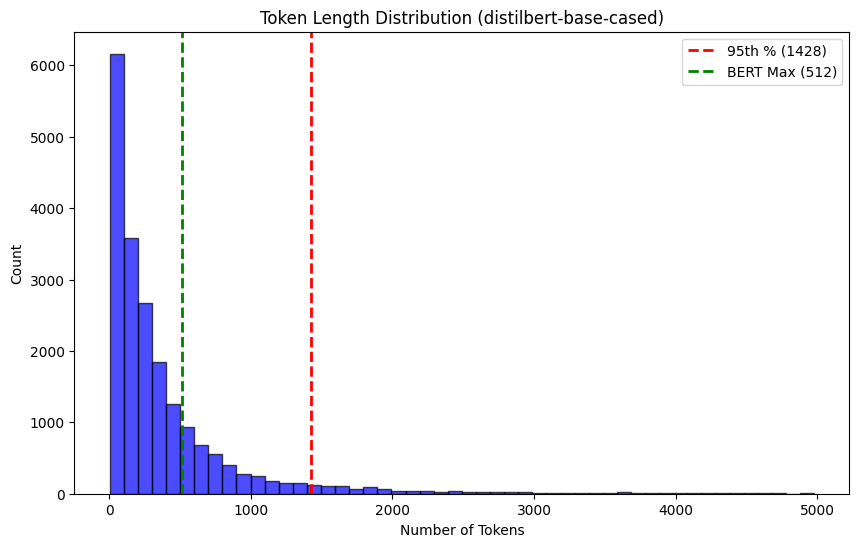

In [18]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50, alpha=0.7, color="blue", edgecolor="black")
plt.axvline(
    p95, color="red", linestyle="dashed", linewidth=2, label=f"95th % ({int(p95)})"
)
plt.axvline(512, color="green", linestyle="dashed", linewidth=2, label="BERT Max (512)")
plt.title(f"Token Length Distribution ({MODEL_CKPT})")
plt.xlabel("Number of Tokens")
plt.ylabel("Count")
plt.legend()
plt.show()

Interpretation: Our data is significantly longer than what DistilBERT can read, even after removing emails > 5000 tokens.

The Constraint: Standard BERT/DistilBERT models have a hard limit of 512 tokens.
Our data:
* p95 (1428): For 5% of our data, the model will cut off the email after the first ~35% (512/1428) of the content.
* p99 (2996): For 1% of our data, the model sees less than 20% (512/2996) of the email.

Why is this dangerous for Phishing?
* If a hacker sends a long email (or a forwarded thread) and hides the malicious link or the "Click Here" button at the very bottom, a standard 512-token model will never see it. It will read the first 512 tokens (which might just be polite conversation), see nothing wrong, and classify it as "Ham."

### HTML cleanup

Let's see if, after stripping HTML and keeping only the text, our p95 would drop:

In [19]:
# lxml is significantly faster than html.parser
!pip install bs4 lxml

In [20]:
import re
from bs4 import BeautifulSoup

WHITESPACE_HANDLER = re.compile(r"\s+")
TAGS_TO_REMOVE = [
    "script",
    "style",
    "meta",
    "noscript",
    "head",
    "title",
    "header",
    "footer",
]


def clean_html_batched(batch):
    cleaned_texts = []

    # Iterate through the list of texts in the batch
    for text in batch["text"]:
        if not text or not isinstance(text, str):
            cleaned_texts.append("")
            continue

        # Use lxml for speed
        # If lxml is not available, fallback to 'html.parser'
        soup = BeautifulSoup(text, "lxml")

        # Decompose noise tags
        # Passing the list directly to soup() is faster than looping through tag names manually
        # This is crucial for BERT. You don't want Javascript or CSS in your embeddings.
        for tag in soup(TAGS_TO_REMOVE):
            tag.decompose()

        # Extract text with separator to prevent word gluing
        # 'separator=" "' ensures </div><div> becomes " " instead of ""
        text_content = soup.get_text(separator=" ")

        # Normalize whitespace using pre-compiled regex
        clean_text = WHITESPACE_HANDLER.sub(" ", text_content).strip()

        cleaned_texts.append(clean_text)

    return {"text": cleaned_texts}

In [21]:
html_cleaned_ds = dataset.map(
    clean_html_batched, batched=True, num_proc=optimal_num_proc
)

Map (num_proc=2):   0%|          | 0/20299 [00:00<?, ? examples/s]

/tmp/ipython-input-1345751579.py:18: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  soup = BeautifulSoup(text, "lxml")


In [22]:
# Reapply tokenization on html_cleaned_ds
tokenized_dataset = html_cleaned_ds.map(
    get_token_len, batched=True
)  # don't use num_proc for Tokenizers, especially 'Fast' ones

Map:   0%|          | 0/20299 [00:00<?, ? examples/s]

In [23]:
# Reapply filter after tokenization
tokenized_dataset = tokenized_dataset.filter(lambda x: x["length"] < 5000)

Filter:   0%|          | 0/20299 [00:00<?, ? examples/s]

In [24]:
# Recalculate percentiles
lengths = tokenized_dataset["length"]
p50 = np.percentile(lengths, 50)  # Median
p95 = np.percentile(lengths, 95)  # 95% of data is below this length
p99 = np.percentile(lengths, 99)  # 99% of data is below this length
max_len = np.max(lengths)

print(f"\n--- Statistics for {MODEL_CKPT} ---")
print(f"Median Token Length: {p50}")
print(f"95th Percentile:     {p95}")
print(f"99th Percentile:     {p99}")
print(f"Maximum Length:      {max_len}")


--- Statistics for distilbert-base-cased ---
Median Token Length: 214.0
95th Percentile:     1428.0
99th Percentile:     2968.3600000000006
Maximum Length:      4977


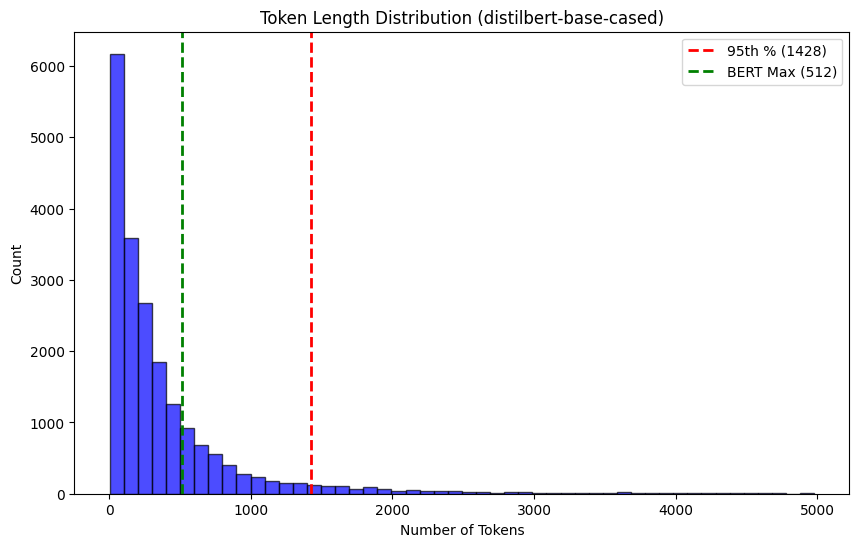

In [25]:
# Replot histogram
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50, alpha=0.7, color="blue", edgecolor="black")
plt.axvline(
    p95, color="red", linestyle="dashed", linewidth=2, label=f"95th % ({int(p95)})"
)
plt.axvline(512, color="green", linestyle="dashed", linewidth=2, label="BERT Max (512)")
plt.title(f"Token Length Distribution ({MODEL_CKPT})")
plt.xlabel("Number of Tokens")
plt.ylabel("Count")
plt.legend()
plt.show()

It's more or less the same, so HTML has already been processed from the source data.

### Removing base64 encoded text

In [26]:
import re

# We look for contiguous strings of 50+ characters consisting of base64-like chars.
MIN_LEN = 50
BASE64_PATTERN = re.compile(r"[A-Za-z0-9+/=]{" + str(MIN_LEN) + r",}")


def remove_base64_batched(batch):
    """
    Input: batch = {'text': ['string 1', 'string 2', ...], 'label': [0, 1, ...]}
    Output: batch (with modified 'text' list)
    """
    # Use a list comprehension to process the whole list at once
    # We also handle None values just in case
    batch["text"] = [
        BASE64_PATTERN.sub(" [BASE64_REMOVED] ", text) if text is not None else ""
        for text in batch["text"]
    ]

In [27]:
base64_removed_ds = html_cleaned_ds.map(
    remove_base64_batched, batched=True, num_proc=optimal_num_proc
)

Map (num_proc=2):   0%|          | 0/20299 [00:00<?, ? examples/s]

In [28]:
# Reapply tokenization and filter on data without html and base64 to see if anything changed
tokenized_dataset = base64_removed_ds.map(get_token_len, batched=True)
tokenized_dataset = tokenized_dataset.filter(lambda x: x["length"] < 5000)

In [29]:
# Recalculate percentiles
lengths = tokenized_dataset["length"]
p50 = np.percentile(lengths, 50)  # Median
p95 = np.percentile(lengths, 95)  # 95% of data is below this length
p99 = np.percentile(lengths, 99)  # 99% of data is below this length
max_len = np.max(lengths)

print(f"\n--- Statistics for {MODEL_CKPT} ---")
print(f"Median Token Length: {p50}")
print(f"95th Percentile:     {p95}")
print(f"99th Percentile:     {p99}")
print(f"Maximum Length:      {max_len}")


--- Statistics for distilbert-base-cased ---
Median Token Length: 214.0
95th Percentile:     1428.0
99th Percentile:     2968.3600000000006
Maximum Length:      4977


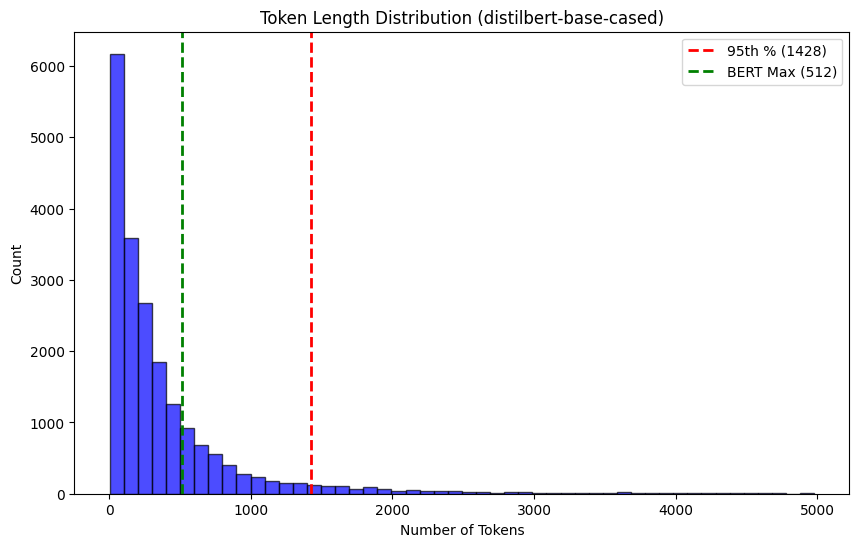

In [30]:
# Replot histogram
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50, alpha=0.7, color="blue", edgecolor="black")
plt.axvline(
    p95, color="red", linestyle="dashed", linewidth=2, label=f"95th % ({int(p95)})"
)
plt.axvline(512, color="green", linestyle="dashed", linewidth=2, label="BERT Max (512)")
plt.title(f"Token Length Distribution ({MODEL_CKPT})")
plt.xlabel("Number of Tokens")
plt.ylabel("Count")
plt.legend()
plt.show()

Again, it's more or less the same. So the text really contains more tokens than what BERT can handle.

### Head-tail tokenization

The text lengths are the same after cleaning HTML and removing base64 encoded strings. Let's do head-tail tokenization instead.

Instead of keeping the first 512 tokens as in standard truncation, we will construct a custom input that keeps the first 25% tokens (header/greeting) and the last 75% tokens (signature/link/call-to-action), and ignore the middle bit.
* After analyzing lots of phishing emails, the call-to-action is often at the end.

Let's create a handler class that wraps the `AutoTokenizer` (since it's based in `rust`, we can't subclass it), that we can use for both training and inference so code isn't repeated:

In [31]:
import torch
from typing import List, Dict, Union, Any
from transformers import PreTrainedTokenizerBase, BatchEncoding


class HeadTailTokenizer:
    """Custom tokenizer that truncates sequences by keeping the head and tail.

    This tokenizer is designed for tasks where the beginning (head) and end (tail)
    of a document contain the most critical information, such as phishing detection
    (headers + signature/CTA) or long document classification. It truncates the
    middle of the sequence rather than the end.

    Attributes:
        tokenizer (PreTrainedTokenizerBase): The underlying Hugging Face tokenizer.
        max_len (int): The maximum sequence length including special tokens.
        head_pct (float): The ratio of content tokens allocated to the head.
        num_special_tokens (int): The count of special tokens added by the model.
        content_capacity (int): The maximum number of actual text tokens allowed.
        head_len (int): The calculated maximum number of tokens for the head.
        tail_len (int): The calculated maximum number of tokens for the tail.
    """

    def __init__(
        self,
        tokenizer: PreTrainedTokenizerBase,
        max_len: int = 512,
        head_pct: float = 0.25,
    ):
        """Initializes the HeadTailTokenizer.

        Args:
            tokenizer: The HuggingFace tokenizer object.
            max_len: Total maximum sequence length (including special tokens).
            head_pct: Percentage of total capacity to allocate to the head (0.0 to 1.0).
                For example, 0.25 means 25% head and 75% tail.
        """
        self.tokenizer = tokenizer
        self.max_len = max_len

        # dynamic_special_tokens: calculate how many tokens this specific model adds automatically
        # e.g., BERT adds 2 ([CLS], [SEP]), RoBERTa adds 2 (<s>, </s>), XLNet might differ.
        self.num_special_tokens = self.tokenizer.num_special_tokens_to_add(pair=False)

        # calculate how many 'real' content tokens we can fit
        self.content_capacity = self.max_len - self.num_special_tokens

        # specific lengths for head and tail
        self.head_len = int(self.content_capacity * head_pct)
        self.tail_len = self.content_capacity - self.head_len

    def _process_one_sequence(self, ids: List[int]) -> List[int]:
        """Stitches the head and tail of a single sequence together.

        If the sequence fits within the content capacity, it is returned as is.
        Otherwise, the middle portion is removed.

        Args:
            ids: A list of integer token IDs (without special tokens).

        Returns:
            List[int]: The processed list of token IDs fitting the capacity.
        """
        if len(ids) <= self.content_capacity:
            # if short enough, just return original IDs
            return ids

        # slice raw content (without special tokens)
        head_ids = ids[: self.head_len]
        tail_ids = ids[-self.tail_len :] if self.tail_len > 0 else []

        return head_ids + tail_ids

    def encode_for_training(
        self, examples: Dict[str, List[Any]]
    ) -> Dict[str, List[List[int]]]:
        """Tokenizes and processes a batch of examples for training.

        This method is designed to be passed to `datasets.Dataset.map()`. It handles
        tokenization, head-tail stitching, and special token insertion, but does
        NOT apply padding (which should be handled by a DataCollator).

        Args:
            examples: A dictionary containing the batch data, expected to have a
                "text" key containing a list of strings.

        Returns:
            dict: A dictionary containing:
                - input_ids (List[List[int]]): List of token ID lists.
                - attention_mask (List[List[int]]): List of attention masks (1 for tokens).
        """
        # Tokenize raw text WITHOUT special tokens first
        # We use fast tokenizer capabilities if available
        raw_outputs = self.tokenizer(
            examples["text"],
            add_special_tokens=False,
            truncation=False,
            padding=False,
            verbose=False,
        )

        final_input_ids = []
        final_attention_masks = []

        for raw_ids in raw_outputs["input_ids"]:
            # Stitch head + tail
            stitched_ids = self._process_one_sequence(raw_ids)

            # Add model-specific special tokens ([CLS]...[SEP] or <s>...</s>)
            # This makes it model-agnostic!
            final_ids = self.tokenizer.build_inputs_with_special_tokens(stitched_ids)

            final_input_ids.append(final_ids)
            # Create mask manually based on length (1 for token, 0 for pad)
            final_attention_masks.append([1] * len(final_ids))

        # Note: We do NOT return tensors here. We return lists.
        # The DataCollator will dynamically pad them to the longest in the batch during training.
        return {"input_ids": final_input_ids, "attention_mask": final_attention_masks}

    def encode_for_inference(
        self, text_list: Union[str, List[str]], device: Union[str, torch.device] = "cpu"
    ) -> BatchEncoding:
        """Encodes text into padded tensors ready for model inference.

        Unlike `encode_for_training`, this method pads the batch to the longest
        sequence (or max_len) and returns PyTorch tensors on the specified device.

        Args:
            text_list: A single string or a list of strings to tokenize.
            device: The device to move the resulting tensors to (e.g., 'cpu', 'cuda').

        Returns:
            BatchEncoding: A Hugging Face object containing 'input_ids' and
            'attention_mask' as PyTorch tensors.
        """
        if isinstance(text_list, str):
            text_list = [text_list]

        # Pre-process (stitch)
        # We duplicate the logic from training, but we need to return padded tensors now.
        raw_outputs = self.tokenizer(
            text_list, add_special_tokens=False, truncation=False, padding=False
        )

        processed_ids = []
        for raw_ids in raw_outputs["input_ids"]:
            stitched = self._process_one_sequence(raw_ids)
            # Add special tokens
            final = self.tokenizer.build_inputs_with_special_tokens(stitched)
            processed_ids.append(final)

        # Pad and convert to Tensor
        # We use the tokenizer's built-in pad method to handle the list of lists
        # We also return tensors directly since you usually want to feed them
        # to a model.
        batch_encoding = self.tokenizer.pad(
            {"input_ids": processed_ids},
            padding="longest",  # Pad to longest in this batch
            max_length=self.max_len,
            return_tensors="pt",  # Return PyTorch tensors
        )

        return batch_encoding.to(device)

To use with training:

In [ ]:
from transformers import (
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)

from transformers import AutoTokenizer

# Scenario A: Using BERT
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
ht_tokenizer = HeadTailTokenizer(tokenizer, max_len=512)

# Scenario B: Switching to RoBERTa (Just change the checkpoint!)
model_checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
ht_tokenizer = HeadTailTokenizer(tokenizer, max_len=512)

# dummy data
data = [{"text": "Start " + "middle " * 1000 + " End", "label": 1}] * 10
dataset = Dataset.from_list(data)

encoded_dataset = dataset.map(
    ht_tokenizer.encode_for_training,
    batched=True,
    batch_size=1000,
)

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=2
)
# Handles conversion to tensors internally, as well as dynamic padding.
# You still submit the base tokenizer with DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=TrainingArguments("test_trainer", per_device_train_batch_size=2),
    train_dataset=encoded_dataset,
    data_collator=data_collator,  # <--- CRITICAL: Handles the padding
)

# trainer.train()

To use for inference (don't run the cell below, just for illustration purposes):

In [ ]:
...
model.eval()  # Set model to eval mode
email_text = (
    "Urgent update... " + "irrelevant info... " * 500 + " ...Click here to verify."
)

# Pass directly to inference method
# It handles stitching -> adding special tokens -> padding -> tensor conversion
inputs = ht_tokenizer.tokenize_for_inference(email_text, device="cpu")

with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=-1)
    print(f"Phishing Probability: {probs[0][1].item():.4f}")
...

## Finalized data flow pre splits

* Start from `David-Egea/phishing-texts` `datasets.DatasetDict`
* Take the 'train' split (only split available)
* Rename `phishing` column to `label` column
* Cast the `label` column type to a `ClassLabel` with names `ham` (0) and `phishing` (1) from `Value('int64')`
* Remove whitespace and NaNs from `text`; remove NaN/float from `label`
* Remove base64 encoded strings from `text`
* Remove HTML tags from `text` using `bs4`
* Normalize unicode strings - apply aggressive anti-homoglyph
* Replace multiple repeating whitespace with a single space and strip ends (leading and trailing)

In [34]:
!pip install text-unidecode

In [35]:
import datasets
from datasets import Dataset, ClassLabel


data_dict = datasets.load_dataset("David-Egea/phishing-texts")
dataset = data_dict["train"]
dataset = dataset.rename_columns({"phishing": "label"})
dataset = dataset.cast_column(
    "label",
    # The order in which you pass in matters. 0 -> ham, 1 -> phishing
    ClassLabel(names=["ham", "phishing"]),
)

Casting the dataset:   0%|          | 0/20301 [00:00<?, ? examples/s]

In [36]:
def filter_function(batch: list) -> list[bool]:
    """Remove undesirables from the passed dataset."""
    # We return a list of Booleans (True = Keep, False = Trash)
    keep_indices = []

    for text, label in zip(batch["text"], batch["label"]):
        # Define logic for what implies a "bad" row
        is_bad_text = (text is None) or (text.strip() == "")
        is_bad_label = (label is None) or (
            isinstance(label, float) and math.isnan(label)
        )

        # if either is bad, we throw them away
        if is_bad_text or is_bad_label:
            keep_indices.append(False)
        else:
            keep_indices.append(True)

    return keep_indices


print(f"Dataset length before filter: {len(dataset)}")
dataset = dataset.filter(filter_function, batched=True, num_proc=optimal_num_proc)
print(f"Dataset length after filter: {len(dataset)}")

Dataset length before filter: 20301


Filter (num_proc=2):   0%|          | 0/20301 [00:00<?, ? examples/s]

Dataset length after filter: 20299


In [37]:
import re

# We look for contiguous strings of 50+ characters consisting of base64-like chars.
MIN_LEN = 50
BASE64_PATTERN = re.compile(r"[A-Za-z0-9+/=]{" + str(MIN_LEN) + r",}")


def remove_base64_batched(batch):
    """
    Input: batch = {'text': ['string 1', 'string 2', ...], 'label': [0, 1, ...]}
    Output: batch (with modified 'text' list)
    """
    # Use a list comprehension to process the whole list at once
    # We also handle None values just in case
    batch["text"] = [
        BASE64_PATTERN.sub(" [BASE64_REMOVED] ", text) if text is not None else ""
        for text in batch["text"]
    ]


dataset = dataset.map(remove_base64_batched, batched=True, num_proc=optimal_num_proc)

Map (num_proc=2):   0%|          | 0/20299 [00:00<?, ? examples/s]

In [38]:
import re

WHITESPACE_HANDLER = re.compile(r"\s+")
TAGS_TO_REMOVE = [
    "script",
    "style",
    "meta",
    "noscript",
    "head",
    "title",
    "header",
    "footer",
]


def clean_html_batched(batch):
    """
    Batched function for Hugging Face datasets.
    Receives a dictionary of lists: {'text': ['<html>...', '<html>...']}
    Returns a dictionary of lists: {'text': ['clean...', 'clean...']}
    """
    cleaned_texts = []

    # Iterate through the list of texts in the batch
    for text in batch["text"]:
        if not text or not isinstance(text, str):
            cleaned_texts.append("")
            continue

        # Use lxml for speed
        # If lxml is not available, fallback to 'html.parser'
        soup = BeautifulSoup(text, "lxml")

        # Decompose noise tags
        # Passing the list directly to soup() is faster than looping through tag names manually
        # This is crucial for BERT. You don't want Javascript or CSS in your embeddings.
        for tag in soup(TAGS_TO_REMOVE):
            tag.decompose()

        # Extract text with separator to prevent word gluing
        # 'separator=" "' ensures </div><div> becomes " " instead of ""
        text_content = soup.get_text(separator=" ")

        # Normalize whitespace using pre-compiled regex
        clean_text = WHITESPACE_HANDLER.sub(" ", text_content).strip()

        cleaned_texts.append(clean_text)

    return {"text": cleaned_texts}


dataset = dataset.map(clean_html_batched, batched=True, num_proc=optimal_num_proc)

Map (num_proc=2):   0%|          | 0/20299 [00:00<?, ? examples/s]

/tmp/ipython-input-3282515795.py:23: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  soup = BeautifulSoup(text, "lxml")


In [39]:
!pip install text-unidecode

In [40]:
from text_unidecode import unidecode


def unicode_aggressive_logic(text: str) -> str:
    if not text:
        return ""

    # Transliterate to ASCII
    # This converts "Pаypal" (Cyrillic) -> "Paypal" (Latin)
    # This is destructive to non-English languages but essential
    # for keyword matching in English-targeted phishing.
    text = unidecode(text)

    return text.strip()


def unicode_aggressive_batched(batch: dict[str, list]) -> dict[str, list]:
    return {"text": [unicode_aggressive_logic(t) for t in batch["text"]]}


dataset = dataset.map(
    unicode_aggressive_batched, batched=True, num_proc=optimal_num_proc
)

Map (num_proc=2):   0%|          | 0/20299 [00:00<?, ? examples/s]

In [41]:
import re

RE_WHITESPACE = re.compile(r"\s+")


def normalize_whitespace(batch):
    """
    Replaces all repeating whitespace characters with a single space
    and strips leading/trailing whitespace.
    """
    batch["text"] = [RE_WHITESPACE.sub(" ", text).strip() for text in batch["text"]]
    return batch


# num_proc uses multiple CPU cores to parallelize the cleaning
dataset = dataset.map(
    normalize_whitespace,
    batched=True,
    num_proc=optimal_num_proc,
)

Map (num_proc=2):   0%|          | 0/20299 [00:00<?, ? examples/s]

In [42]:
cleaned_ds = dataset
cleaned_ds

Dataset({
    features: ['label', 'text'],
    num_rows: 20299
})

## Performing sequential stratified sampling to split the original dataset into train/val/test

End goal: 60/20/20 train/val/test split for the resulting `datasets.DatasetDict`, with class distributions ~(62/38) for ham/phishing preserved as much as possible. Every subset should look like a minature version of the original dataset in terms of features, classes, and noise to ensure representativeness.

Do a two-step split to achieve desired test/val/test splits while ensuring stratification of all three:
1. Split 1 (Train vs Temp) - Separate the primary training set (60%, 40%) into train and temporary pool and ensure stratification.
2. Split 2 (Validation vs Test) - Separate the temporary pool (40%) into the final validation and test sets (20, 20) and ensure stratification.

In [43]:
# after this stage, train_test_split returns a datasets.DatasetDict with 'train' and 'test' keys
# 'test' will be our temporary pool to split again later
temp_dataset_dict = cleaned_ds.train_test_split(
    test_size=0.4,  # 60% for the train
    shuffle=True,
    stratify_by_column="label",
)

In [44]:
val_test_dict = temp_dataset_dict[
    "test"
].train_test_split(
    test_size=0.5,  # 50% of the remaining 40%, resulting in 20% for validation, and 20% for test
    shuffle=True,
    stratify_by_column="label",
)

In [45]:
from datasets import DatasetDict

final_dataset_dict = DatasetDict(
    {
        "train": temp_dataset_dict["train"],
        "validation": val_test_dict["train"],
        "test": val_test_dict["test"],
    }
)

Sanity check - see if the class distributions were actually preserved:

In [46]:
import pandas as pd
from datasets import DatasetDict


def calculate_distribution_percentages(
    dataset_dict: DatasetDict, label_column: str = "label"
) -> pd.DataFrame:
    """
    Calculates the percentage distribution for each split in a DatasetDict.
    """
    distribution_data = {}

    for split_name, dataset in dataset_dict.items():
        # get label counts for a particular split
        counts = dataset.to_pandas()[label_column].value_counts()
        total = len(dataset)
        percentages = (counts / total) * 100
        distribution_data[split_name] = percentages

    # Convert the results to a DataFrame for easy comparison
    distribution_df = pd.DataFrame(distribution_data).fillna(0)

    # Sort by class label for consistent viewing
    distribution_df.sort_index(inplace=True)

    return distribution_df


distribution_table = calculate_distribution_percentages(final_dataset_dict)


print("Class Distribution Comparison (Percentages %)")
print(distribution_table.round(2))

Class Distribution Comparison (Percentages %)
       train  validation   test
label                          
0      62.01        62.0  62.02
1      37.99        38.0  37.98


## Encode text (tokenize + encode)

Note: `Trainer` handles the conversion of `label` to `labels` and it ignores other feature names that aren't pertinent to your particular models (in above, `text`).

Explicitly rename `label` to `labels` -- it's the name transformers models expect. Although `Trainer` handles the conversion for you, it's good to be explicit.

In [47]:
final_dataset_dict = final_dataset_dict.rename_column("label", "labels")

In [48]:
final_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 12179
    })
    validation: Dataset({
        features: ['labels', 'text'],
        num_rows: 4060
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 4060
    })
})

We can achieve dynamic padding later when we use a `DataCollatorWithPadding` submitted to `Trainer(data_collator=data=collator)` or `Trainer(processing_class=tokenizer)`.

When using the latter, you don't have to pass in a `DataCollatorWithPadding` instance, as the default `data_collator` used by the Trainer will be a `DataCollatorWithPadding`.

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-cased"
max_pos_embeddings = 512
map_batch_size = 1024


tokenizer = AutoTokenizer.from_pretrained(checkpoint)
ht_tokenizer = HeadTailTokenizer(tokenizer, max_len=max_pos_embeddings)

In [50]:
encoded_datasets = final_dataset_dict.map(
    ht_tokenizer.encode_for_training, batched=True, batch_size=map_batch_size
)

Map:   0%|          | 0/12179 [00:00<?, ? examples/s]

Map:   0%|          | 0/4060 [00:00<?, ? examples/s]

Map:   0%|          | 0/4060 [00:00<?, ? examples/s]

We can see that, for `distilbert-base-cased`, it adds (2) new columns: `input_ids` and `attention_mask`.

In [51]:
encoded_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'text', 'input_ids', 'attention_mask'],
        num_rows: 12179
    })
    validation: Dataset({
        features: ['labels', 'text', 'input_ids', 'attention_mask'],
        num_rows: 4060
    })
    test: Dataset({
        features: ['labels', 'text', 'input_ids', 'attention_mask'],
        num_rows: 4060
    })
})

Double check that the data collator is dynamically padding a batch properly:

In [52]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

samples = encoded_datasets["train"][:4]
# remove all features in the dataset that are not pertinent to the model
samples = {k: v for k, v in samples.items() if k not in ["text"]}
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([4]),
 'input_ids': torch.Size([4, 286]),
 'attention_mask': torch.Size([4, 286])}

Double check that the lengths of `input_ids` and `attention_mask` don't go past the max_pos_embeddings we defined:

In [53]:
MAX_LEN = 512


def is_valid_length(example):
    return (
        len(example["input_ids"]) <= MAX_LEN
        and len(example["attention_mask"]) <= MAX_LEN
    )


# Check all splits at once
all_valid = all(
    all(is_valid_length(ex) for ex in encoded_datasets[split])
    for split in encoded_datasets
)

print(f"All sequences represent valid lengths (<= {MAX_LEN}): {all_valid}")

All sequences represent valid lengths (<= 512): True


In [65]:
encoded_datasets["train"].features["labels"]

ClassLabel(names=['ham', 'phishing'])

## Data pipeline in W&B

Using the steps we performed during the EDA section, let's create a functional W&B data pipeline.

**Ingest**
* Get raw dataset from huggingface/datasets - https://huggingface.co/datasets/David-Egea/phishing-texts
* Log as a `phishing-texts-raw` artifact with no modifications in Arrow format

Data cleaning
* Goal: to make a general, stable, clean source that can be used for prior to encoding, which can change depending on the transformer architecture used.

Steps:
* Take in `phishing-texts-raw` as an input dependency
* Rename `phishing` column to `label` column
* Cast the `label` column type to a `ClassLabel` with names `ham` (0) and `phishing` (1) from `Value('int64')`
* Remove whitespace and NaNs from `text`; remove NaN/float from `label`
* Remove base64 encoded strings from `text`
* Remove HTML tags from `text` using `bs4`
* Normalize unicode strings - apply aggressive anti-homoglyph
* Replace multiple repeating whitespace with a single space and strip ends (leading and trailing)
* Do sequential stratified sampling to split the dataset into train/val/test 60/20/20 or a specified split
* Log as a `phishing-texts-clean` artifact in Arrow format

Tokenization and encoding
* Goal: to turn `phishing-texts-clean` into tensors for `transformer` training.

Steps:
* Rename `label` column to `labels` - standard HF convention
* Take in `phishing-texts-clean` as an input dependency
* Perform head-tail tokenization to encode text into PyTorch tensors - **make sure the same tokenization is applied during inference**
    * Implicitly removes `text` column
* Log as a `phishing-texts-encoded-head-tail` artifact in Arrow format
    * If we were to change tokenization, `phishing-texts-encoded-{scheme}` would be the name


### Run me first - common error decorator

This is so we don't have to write try-except blocks everywhere.

In [71]:
import functools
import traceback
from typing import Any, Callable, Optional

import wandb


def wandb_track_failure(func: Optional[Callable] = None, *, alert: bool = False):
    """Wraps a function to capture and log exceptions to Weights & Biases.

    This decorator ensures that if the wrapped function crashes, the exception
    details, traceback, and execution context (args/kwargs) are logged to W&B
    before the program exits. It uploads a detailed crash report file, tags
    the run as 'crashed', and optionally sends a W&B alert.

    Args:
        func: The function to be decorated.
        alert: If True, sends a W&B alert (e.g., via Slack or Email) upon failure.

    Returns:
        Callable: The wrapped function which preserves the original signature.

    Raises:
        Exception: Re-raises the caught exception to ensure the process terminates
            with a non-zero exit code and W&B marks the run as 'failed'.
    """
    # Handle the case where arguments are passed to the decorator
    # This allows usage as both @wandb_track_failure (func is not None)
    # and @wandb_track_failure(alert=False) (func is None initially)
    if func is None:
        return functools.partial(wandb_track_failure, alert=alert)

    @functools.wraps(func)
    def wrapper(*args: Any, **kwargs: Any) -> Any:
        try:
            return func(*args, **kwargs)
        except Exception as e:
            if wandb.run is not None:
                tb_str = traceback.format_exc()

                # Capture context safely
                # specific to your needs: truncate long strings/tensors to avoid
                # bloating logs or leaking PII
                def safe_repr(obj):
                    """Helper to safely represent objects as strings with truncation."""
                    s = repr(obj)
                    return s[:1000] + "..." if len(s) > 1000 else s

                # Construct a readable summary of what was happening when it crashed
                context_str = (
                    f"Function: {func.__name__}\n"
                    f"Step: {wandb.run.step}\n"
                    f"Args: {safe_repr(args)}\n"
                    f"Kwargs: {safe_repr(kwargs)}"
                )

                # Store basic error info in the run summary for quick viewing in the UI
                wandb.run.summary["error_message"] = str(e)
                wandb.run.summary["crash_step"] = wandb.run.step

                # Save full details to a local file and upload to W&B attached to the run
                # This ensures long tracebacks aren't truncated by the UI
                filename = "crash_report.txt"
                with open(filename, "w") as f:
                    f.write(f"--- ERROR ---\n{str(e)}\n\n")
                    f.write(f"--- CONTEXT ---\n{context_str}\n\n")
                    f.write(f"--- TRACEBACK ---\n{tb_str}")

                # Save immediately ensures it uploads even if the script dies moments later.
                # 'policy="now"' forces the file to upload immediately rather than waiting for run finish.
                wandb.save(filename, policy="now")

                # Tag the run for easy filtering in the dashboard (e.g., filtering for "crashed" runs)
                wandb.run.tags = wandb.run.tags + ("crashed",)

                # (Optional) Send an active wandb.Alert to slack/email if configured
                # This requires W&B Alerts to be configured in the project settings.
                if alert:
                    wandb.alert(
                        title=f"Run {wandb.run.name or wandb.run.id} Failed",
                        text=f"**Error:** `{str(e)}`\n\n**Function:** `{func.__name__}`\n**Step:** {wandb.run.step}",
                        level=wandb.AlertLevel.ERROR,
                    )

            # CRITICAL: re-raise the exception
            # This ensures W&B marks the run state as "FAILED" (Red)
            # 'raise' (bare) is preferred over 'raise e' to preserve the original stack trace
            raise

    return wrapper

Usage (parametrized). I like to set an alerts as explicit arguments, not implicit:
```python
@wandb_track_failure
def alert_always(bar: str, baz: int):
    ...
```

```python
@wandb_track_failure(alert=True)
def experimental_function():
    ...
```

### Phase 1: Ingest

In [73]:
import tempfile
import datasets
import wandb

from wandb.sdk.wandb_run import Run  # Type hint for the run object


@wandb_track_failure
def ingest_data(
    run: Run, dataset_path, config_name: str = None, dataset_revision: str = None
):
    """Downloads a Hugging Face dataset and logs it as a W&B artifact.

    This function downloads the specified dataset using the `datasets` library. It
    standardizes the data into a `DatasetDict`, saves it to a temporary directory,
    and creates a W&B artifact containing the raw files and associated metadata
    (schema, split sizes, and source URL). A preview of the first 50 rows is also
    logged to the run.

    Args:
        run: The active Weights & Biases run object.
        dataset_path (str): The path or identifier of the dataset on Hugging Face.
        config_name: The configuration name of the dataset, if applicable.
        dataset_revision: The specific version or commit hash of the dataset.

    Raises:
        RuntimeError: If the dataset fails to download or load.
    """
    print(f"🚀 Starting run: {run.name}")
    print(f"⚙️ Config: {run.config}")
    print(f"⬇️ Downloading {dataset_path}...")
    try:
        raw_data_dict = datasets.load_dataset(
            dataset_path,
            name=config_name,
            revision=dataset_revision,
        )
    except Exception as e:
        raise RuntimeError(f"❌ Failed to load dataset: {e}")

    # Ensure it is a DatasetDict (in case load_dataset returns a single split)
    if isinstance(raw_data_dict, datasets.Dataset):
        raw_data_dict = datasets.DatasetDict({"train": raw_data_dict})

    with tempfile.TemporaryDirectory() as temp_dir:
        print(f"💾 Saving dataset to {temp_dir}...")
        raw_data_dict.save_to_disk(temp_dir)

        # Metadata extraction
        ref_split_name = list(raw_data_dict.keys())[0]
        ref_split = raw_data_dict[ref_split_name]
        split_sizes = {split: len(ds) for split, ds in raw_data_dict.items()}
        ds_info = ref_split.info

        metadata = {
            **run.config,
            "source_url": f"https://huggingface.co/datasets/{dataset_path}",
            "revision": dataset_revision or "main/latest",
            "description": ds_info.description or "No description",
            "splits": list(split_sizes.keys()),
            "label_mapping": {"0": "ham", "1": "phishing"},
            "total_rows": sum(split_sizes.values()),
            "split_sizes": split_sizes,
            # Ensure features are JSON-safe serializable objects
            "schema": {k: str(v) for k, v in ref_split.features.items()},
        }

        artifact_name = f"{dataset_path.split('/')[-1]}-raw"
        artifact = wandb.Artifact(
            name=artifact_name,
            type="dataset",
            description=f"Raw dataset sourced from {dataset_path}.",
            metadata=metadata,
        )
        artifact.add_dir(temp_dir)
        print("💾 Logging artifact...")
        run.log_artifact(artifact)

        # Log a preview table to W&B for quick inspection
        # This converts the first 50 rows of the reference split to a W&B Table
        print("👀 Logging preview table with size 50...")
        preview_df = ref_split.select(range(min(len(ref_split), 50))).to_pandas()
        run.log({"raw_data_preview": wandb.Table(dataframe=preview_df)})

    print("✅ Ingestion complete!")

A great way to keep the codebase clean and your team sane is to explicitly separate functional parameters (arguments your function logic needs) with contextual metadata (info your dashboard wants).

I typically employ a nested namespace pattern in run configs, with `params` and `meta` fields.

It works because:
* For maintainers: it is immediately obvious which values affect code logic (`params`) and which are just notes for humans (`meta`).
* For code: you can just use Python dict unpacking (`**run.config.params`) or explicit feeding into the function's named parameters to feed arguments cleanly.
* For W&B: the dashboard handles nested configs beautifully (e.g., `params.batch_size`).

In [74]:
from datetime import datetime, timezone

ts = datetime.now(timezone.utc).strftime("%Y-%m-%dT%H-%M-%SZ")

project_name = "nlp-phishing-detection"

config = {
    # These are for the main function body.
    # It clearly tells your team:
    # "If it’s inside params, don’t touch it unless you want behavior to change."
    "params": {
        "hf_dataset_path": "David-Egea/phishing-texts",
        "hf_config_name": None,
        "hf_dataset_revision": None,
    },
    # These are for the dashboard / humans
    # If it's inside meta, change it to describe your run."
    "meta": {
        "task": "binary phishing detection dataset",
        "output_format": "hf_arrow_dir",  # hey, this was saved by datasets.save_to_disk
        "output_structure": "datasets.DatasetDict",  # The semantic structure (it contains train/test splits, it's not a dataset.Dataset)
        "recommended_loader": "datasets.load_from_disk",
    },
}

with wandb.init(
    project=project_name,
    name=f"ingest-hf-phishing-texts-{ts}",
    tags=["dev", "raw", "phishing-texts"],
    job_type="ingest",
    config=config,
) as run:
    ingest_data(
        run,
        dataset_path=config["params"]["hf_dataset_path"],
        config_name=config["params"]["hf_config_name"],
        dataset_revision=config["params"]["hf_dataset_revision"],
    )

🚀 Starting run: ingest-hf-phishing-texts-2025-12-13T07-30-22Z
⚙️ Config: {'params': {'hf_dataset_revision': None, 'hf_dataset_path': 'David-Egea/phishing-texts', 'hf_config_name': None}, 'meta': {'output_structure': 'datasets.DatasetDict', 'recommended_loader': 'datasets.load_from_disk', 'task': 'binary phishing detection dataset', 'output_format': 'hf_arrow_dir'}}
⬇️ Downloading David-Egea/phishing-texts...
💾 Saving dataset to /tmp/tmpg21ktlgy...


Saving the dataset (0/1 shards):   0%|          | 0/20301 [00:00<?, ? examples/s]

wandb: Adding directory to artifact (/tmp/tmpg21ktlgy)... Done. 0.4s


💾 Logging artifact...
👀 Logging preview table with size 50...
✅ Ingestion complete!


### Phase 2: Clean

In [75]:
import importlib.metadata
import math
import re
import os
import multiprocessing
import shutil
from collections import Counter
from typing import Dict, Optional, List

import wandb
import datasets
from datasets import ClassLabel, DatasetDict, load_from_disk

# CONSTANTS & COMPILED REGEX
MIN_BASE64_LEN = 50
BASE64_PATTERN = re.compile(r"[A-Za-z0-9+/=]{" + str(MIN_BASE64_LEN) + r",}")
RE_WHITESPACE = re.compile(r"\s+")
TAGS_TO_REMOVE = [
    "script",
    "style",
    "meta",
    "noscript",
    "head",
    "title",
    "header",
    "footer",
]
OPTIMAL_NUM_PROC = min(multiprocessing.cpu_count(), 4)


# CLEANING HELPER FUNCTIONS
# These MUST be defined at the top level for multiprocessing pickling to work
def filter_bad_rows(batch: dict[str, list]) -> dict[str, list]:
    """Returns False for rows with empty text or NaN labels."""
    keep_indices = []
    for text, label in zip(batch["text"], batch["label"]):
        is_bad_text = (text is None) or (text.strip() == "")
        is_bad_label = (label is None) or (
            isinstance(label, float) and math.isnan(label)
        )
        keep_indices.append(not (is_bad_text or is_bad_label))
    return keep_indices


def remove_base64_batched(batch: dict[str, list]) -> dict[str, list]:
    """Replaces long contiguous strings of base64 characters."""
    batch["text"] = [
        BASE64_PATTERN.sub(" [BASE64_REMOVED] ", text) if text is not None else ""
        for text in batch["text"]
    ]
    return batch


def clean_html_batched(batch):
    cleaned_texts = []

    # Iterate through the list of texts in the batch
    for text in batch["text"]:
        if not text or not isinstance(text, str):
            cleaned_texts.append("")
            continue

        # Use lxml for speed
        # If lxml is not available, fallback to 'html.parser'
        soup = BeautifulSoup(text, "lxml")

        # Decompose noise tags
        # Passing the list directly to soup() is faster than looping through tag names manually
        # This is crucial for BERT. You don't want Javascript or CSS in your embeddings.
        for tag in soup(TAGS_TO_REMOVE):
            tag.decompose()

        # Extract text with separator to prevent word gluing
        # 'separator=" "' ensures </div><div> becomes " " instead of ""
        text_content = soup.get_text(separator=" ")

        # Normalize whitespace using pre-compiled regex
        clean_text = RE_WHITESPACE.sub(" ", text_content).strip()

        cleaned_texts.append(clean_text)

    return {"text": cleaned_texts}


def normalize_whitespace_batched(batch: dict[str, list]) -> dict[str, list]:
    """Collapses multiple spaces and strips ends."""
    batch["text"] = [RE_WHITESPACE.sub(" ", text).strip() for text in batch["text"]]
    return batch


def unicode_aggressive_logic(text: str) -> str:
    if not text:
        return ""

    # Transliterate to ASCII
    # This converts "Pаypal" (Cyrillic) -> "Paypal" (Latin)
    # This is destructive to non-English languages but essential
    # for keyword matching in English-targeted phishing.
    text = unidecode(text)

    return text.strip()


def unicode_aggressive_batched(batch: dict[str, list]) -> dict[str, list]:
    return {"text": [unicode_aggressive_logic(t) for t in batch["text"]]}


# MAIN PIPELINE FUNCTION
@wandb_track_failure
def clean_and_split_data(
    run: wandb.sdk.wandb_run.Run,
    input_artifact_name: str,
    split_ratios: Dict[str, float],
    seed: int = 42,
    cleaning_flags: Optional[Dict[str, bool]] = None,
    rename_map: Optional[Dict[str, str]] = None,
):
    """
    Main logic to clean and split the dataset.

    Args:
        run: The active W&B run object (used for logging artifacts/summaries).
        input_artifact_name: The string name of the W&B artifact to download.
        split_ratios: Dict containing 'train', 'val', 'test' floats (must sum to 1.0).
        seed: Random seed for reproducibility.
        cleaning_flags: Dict to toggle specific cleaning steps (e.g., {'remove_html': True}).
        rename_map: Dict to map old column names to new ones. Defaults to {'phishing': 'label'}.
    """

    # Handle mutable defaults
    if cleaning_flags is None:
        cleaning_flags = {
            "remove_html": True,
            "remove_base64": True,
            "fix_unicode": True,
        }
    if rename_map is None:
        rename_map = {"phishing": "label"}

    print(f"🚀 Starting run: {run.name}")
    print(f"⚙️ Config: {run.config}")

    # Load Artifact
    print(f"⬇️ Downloading artifact: {input_artifact_name}")
    input_artifact = run.use_artifact(input_artifact_name)
    artifact_dir = input_artifact.download()
    dataset = load_from_disk(artifact_dir)
    dataset = dataset["train"]
    # Calculate raw length before cleaning - for impact stats
    raw_char_count = sum([len(t) for t in dataset["text"] if t])

    # Rename and cast columns
    if "phishing" in dataset.column_names and rename_map.get("phishing"):
        print(f"📝 Renaming columns using dict: {rename_map}")
        dataset = dataset.rename_column("phishing", rename_map["phishing"])

    print("📝 Casting 'label' column...")
    dataset = dataset.cast_column("label", ClassLabel(names=["ham", "phishing"]))

    # Filtering
    initial_len = len(dataset)
    dataset = dataset.filter(filter_bad_rows, batched=True, num_proc=OPTIMAL_NUM_PROC)
    dropped_count = initial_len - len(dataset)
    print(f"🧹 Filtered {dropped_count} rows (NaN/Empty/None).")

    # Cleaning
    if cleaning_flags.get("remove_base64"):
        print("🧹 Removing Base64...")
        dataset = dataset.map(
            remove_base64_batched, batched=True, num_proc=OPTIMAL_NUM_PROC
        )

    if cleaning_flags.get("remove_html"):
        print("🧹 Removing HTML...")
        dataset = dataset.map(
            clean_html_batched, batched=True, num_proc=OPTIMAL_NUM_PROC
        )

    if cleaning_flags.get("fix_unicode"):
        print("🧹 Transliterating to ASCII...")
        dataset = dataset.map(
            unicode_aggressive_batched, batched=True, num_proc=OPTIMAL_NUM_PROC
        )

    print("🧹 Normalizing whitespaces...")
    dataset = dataset.map(
        normalize_whitespace_batched, batched=True, num_proc=OPTIMAL_NUM_PROC
    )

    # Needed for impact stats
    clean_char_count = sum([len(t) for t in dataset["text"]])

    # Sequential stratified split - proven to preserve class ratios
    # But a sanity check is here
    assert abs(sum(split_ratios.values()) - 1.0) < 1e-5, "Split ratios must sum to 1"

    # Calc dynamic split sizes
    test_val_size = 1.0 - split_ratios["train"]

    print(f"🔀 Stratified split 1 with seed: {seed}...")
    split_1 = dataset.train_test_split(
        test_size=test_val_size, shuffle=True, seed=seed, stratify_by_column="label"
    )

    # Calculate relative size of test vs (val + test)
    test_fraction_of_rest = split_ratios["test"] / (
        split_ratios["val"] + split_ratios["test"]
    )

    print(f"🔀 Stratified split 2 with seed: {seed}...")
    split_2 = split_1["test"].train_test_split(
        test_size=test_fraction_of_rest,
        shuffle=True,
        seed=seed,
        stratify_by_column="label",
    )

    print("✍️ Creating datasets.DatasetDict from stratified splits...")
    final_dataset = DatasetDict(
        {
            "train": split_1["train"],
            "validation": split_2["train"],
            "test": split_2["test"],
        }
    )

    # Verification and logging
    # See if stratification worked
    summary_stats = {}
    for split_name, ds in final_dataset.items():
        count = len(ds)
        class_1_ratio = Counter(ds["label"]).get(1, 0) / count if count > 0 else 0
        summary_stats[f"{split_name}_count"] = count
        summary_stats[f"{split_name}_phishing_ratio"] = class_1_ratio

    print("🔎 Logging summary stats to run summary...")
    run.summary.update(summary_stats)

    # Statistics & Metadata Prep (Artifact Metadata)
    print("📊 Calculating NLP statistics for metadata...")

    # NLP Stats - calculated on 'train' split
    # Why train? It's the standard for setting model max_length / vocab.
    train_texts = final_dataset["train"]["text"]
    text_lengths = [len(t) for t in train_texts]

    nlp_stats = {
        "train_avg_doc_length": sum(text_lengths) / len(text_lengths)
        if text_lengths
        else 0,
        "train_max_doc_length": max(text_lengths) if text_lengths else 0,
        "train_min_doc_length": min(text_lengths) if text_lengths else 0,
    }

    # Simple whitespace tokenization to estimate for transformers models
    train_tokens_list = [t.split() for t in train_texts]
    train_word_counts = [len(t) for t in train_tokens_list]
    all_tokens = [token for sublist in train_tokens_list for token in sublist]
    vocab_counter = Counter(all_tokens)

    nlp_stats.update(
        {
            # Word counts
            "train_avg_word_count": sum(train_word_counts) / len(train_word_counts)
            if train_word_counts
            else 0,
            "train_p95_word_count": sorted(train_word_counts)[
                int(len(train_word_counts) * 0.95)
            ]
            if train_word_counts
            else 0,
            # Vocabulary - indicates how diverse the language is
            "train_vocab_size": len(vocab_counter),
            "train_total_tokens": len(all_tokens),
            # type-token ratio - unique_words/total_words = a low TTR indicates repetitive text, while a high TTR indicates complex text
            "train_ttr": len(vocab_counter) / len(all_tokens) if all_tokens else 0,
            # Top keywords - optional but nice to see
            "train_top_10_words": dict(vocab_counter.most_common(10)),
        }
    )

    # For NLP stats, filter out complex types - they cannot be in summary
    flat_nlp_stats = {
        k: v for k, v in nlp_stats.items() if isinstance(v, (int, float, str))
    }
    print("🔎 Logging NLP stats to run summary...")
    run.summary.update(flat_nlp_stats)

    impact_stats = {
        "cleaning_compression_ratio": clean_char_count / raw_char_count
        if raw_char_count > 0
        else 0,
        "total_chars_removed": raw_char_count - clean_char_count,
    }
    print("🔎 Logging impact stats to run summary...")
    run.summary.update(impact_stats)

    # Ontology (extract mapping programmatically from features to be safe)
    # This returns {'ham': 0, 'phishing': 1}
    label_feature = final_dataset["train"].features["label"]
    label_mapping = {name: i for i, name in enumerate(label_feature.names)}

    # Save artifact to a fixed dir
    output_name = "phishing-texts-clean"
    save_path = f"artifacts/{output_name}"
    if os.path.exists(save_path):
        shutil.rmtree(save_path)

    print(f"💾 Saving datasets.DatasetDict to {save_path}...")
    final_dataset.save_to_disk(save_path)

    env_stats = {
        "lib_version_datasets": importlib.metadata.version("datasets"),
        "lib_version_bs4": importlib.metadata.version("beautifulsoup4"),
        "lib_version_unidecode": importlib.metadata.version("text-unidecode"),
        "lib_version_wandb": importlib.metadata.version("wandb"),
    }

    processed_artifact = wandb.Artifact(
        name=output_name,
        type="dataset",
        metadata={
            # pass in config with meta and params fields
            **config,
            # Ontology
            "label_mapping": label_mapping,
            "columns": [
                str(c) for c in final_dataset["train"].column_names
            ],  # ensure type safety
            # Distribution & Health
            "original_size": initial_len,
            "dropped_rows": dropped_count,
            **summary_stats,  # adds train_count, train_phishing_ratio, etc.
            **impact_stats,  # adds cleaning_compression_ratio and chars removed by the cleaning process
            # NLP Stats
            **nlp_stats,
            # Technical
            "output_type": "datasets.DatasetDict",
            "schema": {k: str(v) for k, v in final_dataset["train"].features.items()},
            # Environment
            **env_stats,
        },
    )
    processed_artifact.add_dir(save_path)
    print("💾 Logging artifact...")
    run.log_artifact(processed_artifact)
    print("✅ Cleaning pipeline finished!")

In [76]:
from datetime import datetime, timezone

ts = datetime.now(timezone.utc).strftime("%Y-%m-%dT%H-%M-%SZ")

project_name = "nlp-phishing-detection"

default_config = {
    # PARAMS: Things we might want to sweep over or tune.
    # These directly affect the mathematical/logical outcome of the data.
    "params": {
        "seed": 42,  # for splitting
        "split_ratios": {"train": 0.6, "val": 0.2, "test": 0.2},
        "cleaning": {
            "remove_html": True,
            "remove_base64": True,
            "fix_unicode": True,
        },
    },
    # META: Static definitions, lineage, inputs, and outputs.
    # These describe the environment and the data contract.
    "meta": {
        "task": "binary phishing detection dataset",
        "input_artifact": "phishing-texts-raw:v0",
        "output_format": "hf_arrow_dir",
        "output_structure": "datasets.DatasetDict",
        "recommended_loader": "datasets.load_from_disk",
    },
}

with wandb.init(
    project=project_name,
    name=f"clean-split-hf-phishing-texts-{ts}",
    job_type="clean",
    tags=["preprocessing", "stratified-split", "dev"],
    config=default_config,
) as run:
    clean_and_split_data(
        run=run,
        input_artifact_name=run.config.meta["input_artifact"],
        split_ratios=run.config.params["split_ratios"],
        seed=run.config.params["seed"],
        cleaning_flags=run.config.params["cleaning"],
    )

🚀 Starting run: clean-split-hf-phishing-texts-2025-12-13T07-31-42Z
⚙️ Config: {'params': {'cleaning': {'remove_html': True, 'remove_base64': True, 'fix_unicode': True}, 'seed': 42, 'split_ratios': {'train': 0.6, 'val': 0.2, 'test': 0.2}}, 'meta': {'task': 'binary phishing detection dataset', 'input_artifact': 'phishing-texts-raw:v0', 'output_format': 'hf_arrow_dir', 'output_structure': 'datasets.DatasetDict', 'recommended_loader': 'datasets.load_from_disk'}}
⬇️ Downloading artifact: phishing-texts-raw:v0


wandb:   4 of 4 files downloaded.  


📝 Renaming columns using dict: {'phishing': 'label'}
📝 Casting 'label' column...


Filter (num_proc=2):   0%|          | 0/20301 [00:00<?, ? examples/s]

🧹 Filtered 2 rows (NaN/Empty/None).
🧹 Removing Base64...


Map (num_proc=2):   0%|          | 0/20299 [00:00<?, ? examples/s]

🧹 Removing HTML...


Map (num_proc=2):   0%|          | 0/20299 [00:00<?, ? examples/s]

/tmp/ipython-input-2962143040.py:54: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  soup = BeautifulSoup(text, "lxml")


🧹 Transliterating to ASCII...


Map (num_proc=2):   0%|          | 0/20299 [00:00<?, ? examples/s]

🧹 Normalizing whitespaces...


Map (num_proc=2):   0%|          | 0/20299 [00:00<?, ? examples/s]

🔀 Stratified split 1 with seed: 42...
🔀 Stratified split 2 with seed: 42...
✍️ Creating datasets.DatasetDict from stratified splits...
🔎 Logging summary stats to run summary...
📊 Calculating NLP statistics for metadata...
🔎 Logging NLP stats to run summary...
🔎 Logging impact stats to run summary...
💾 Saving datasets.DatasetDict to artifacts/phishing-texts-clean...


Saving the dataset (0/1 shards):   0%|          | 0/12179 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4060 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4060 [00:00<?, ? examples/s]

wandb: Adding directory to artifact (artifacts/phishing-texts-clean)... Done. 0.2s


💾 Logging artifact...
✅ Cleaning pipeline finished!


cleaning_compression_ratio,0.98866
test_count,4060
test_phishing_ratio,0.38005
total_chars_removed,575290
train_avg_doc_length,3006.44913
train_avg_word_count,594.58248
train_count,12179
train_max_doc_length,17029916
train_min_doc_length,1
train_p95_word_count,1086
+6,...


### Phase 3: Tokenize and encode

#### HeadTailTokenizer

In [77]:
import torch
from typing import List, Dict, Union, Any
from transformers import PreTrainedTokenizerBase, BatchEncoding


class HeadTailTokenizer:
    """Custom tokenizer that truncates sequences by keeping the head and tail.

    This tokenizer is designed for tasks where the beginning (head) and end (tail)
    of a document contain the most critical information, such as phishing detection
    (headers + signature/CTA) or long document classification. It truncates the
    middle of the sequence rather than the end.

    Attributes:
        tokenizer (PreTrainedTokenizerBase): The underlying Hugging Face tokenizer.
        max_len (int): The maximum sequence length including special tokens.
        head_pct (float): The ratio of content tokens allocated to the head.
        num_special_tokens (int): The count of special tokens added by the model.
        content_capacity (int): The maximum number of actual text tokens allowed.
        head_len (int): The calculated maximum number of tokens for the head.
        tail_len (int): The calculated maximum number of tokens for the tail.
    """

    def __init__(
        self,
        tokenizer: PreTrainedTokenizerBase,
        max_len: int = 512,
        head_pct: float = 0.25,
    ):
        """Initializes the HeadTailTokenizer.

        Args:
            tokenizer: The HuggingFace tokenizer object.
            max_len: Total maximum sequence length (including special tokens).
            head_pct: Percentage of total capacity to allocate to the head (0.0 to 1.0).
                For example, 0.25 means 25% head and 75% tail.
        """
        self.tokenizer = tokenizer
        self.max_len = max_len

        # dynamic_special_tokens: calculate how many tokens this specific model adds automatically
        # e.g., BERT adds 2 ([CLS], [SEP]), RoBERTa adds 2 (<s>, </s>), XLNet might differ.
        self.num_special_tokens = self.tokenizer.num_special_tokens_to_add(pair=False)

        # calculate how many 'real' content tokens we can fit
        self.content_capacity = self.max_len - self.num_special_tokens

        # specific lengths for head and tail
        self.head_len = int(self.content_capacity * head_pct)
        self.tail_len = self.content_capacity - self.head_len

    def _process_one_sequence(self, ids: List[int]) -> List[int]:
        """Stitches the head and tail of a single sequence together.

        If the sequence fits within the content capacity, it is returned as is.
        Otherwise, the middle portion is removed.

        Args:
            ids: A list of integer token IDs (without special tokens).

        Returns:
            List[int]: The processed list of token IDs fitting the capacity.
        """
        if len(ids) <= self.content_capacity:
            # if short enough, just return original IDs
            return ids

        # slice raw content (without special tokens)
        head_ids = ids[: self.head_len]
        tail_ids = ids[-self.tail_len :] if self.tail_len > 0 else []

        return head_ids + tail_ids

    def encode_for_training(
        self, examples: Dict[str, List[Any]]
    ) -> Dict[str, List[List[int]]]:
        """Tokenizes and processes a batch of examples for training.

        This method is designed to be passed to `datasets.Dataset.map()`. It handles
        tokenization, head-tail stitching, and special token insertion, but does
        NOT apply padding (which should be handled by a DataCollator).

        Args:
            examples: A dictionary containing the batch data, expected to have a
                "text" key containing a list of strings.

        Returns:
            dict: A dictionary containing:
                - input_ids (List[List[int]]): List of token ID lists.
                - attention_mask (List[List[int]]): List of attention masks (1 for tokens).
        """
        # Tokenize raw text WITHOUT special tokens first
        # We use fast tokenizer capabilities if available
        raw_outputs = self.tokenizer(
            examples["text"],
            add_special_tokens=False,
            truncation=False,
            padding=False,
            verbose=False,
        )

        final_input_ids = []
        final_attention_masks = []

        for raw_ids in raw_outputs["input_ids"]:
            # Stitch head + tail
            stitched_ids = self._process_one_sequence(raw_ids)

            # Add model-specific special tokens ([CLS]...[SEP] or <s>...</s>)
            # This makes it model-agnostic!
            final_ids = self.tokenizer.build_inputs_with_special_tokens(stitched_ids)

            final_input_ids.append(final_ids)
            # Create mask manually based on length (1 for token, 0 for pad)
            final_attention_masks.append([1] * len(final_ids))

        # Note: We do NOT return tensors here. We return lists.
        # The DataCollator will dynamically pad them to the longest in the batch during training.
        return {"input_ids": final_input_ids, "attention_mask": final_attention_masks}

    def encode_for_inference(
        self, text_list: Union[str, List[str]], device: Union[str, torch.device] = "cpu"
    ) -> BatchEncoding:
        """Encodes text into padded tensors ready for model inference.

        Unlike `encode_for_training`, this method pads the batch to the longest
        sequence (or max_len) and returns PyTorch tensors on the specified device.

        Args:
            text_list: A single string or a list of strings to tokenize.
            device: The device to move the resulting tensors to (e.g., 'cpu', 'cuda').

        Returns:
            BatchEncoding: A Hugging Face object containing 'input_ids' and
            'attention_mask' as PyTorch tensors.
        """
        if isinstance(text_list, str):
            text_list = [text_list]

        # Pre-process (stitch)
        # We duplicate the logic from training, but we need to return padded tensors now.
        raw_outputs = self.tokenizer(
            text_list, add_special_tokens=False, truncation=False, padding=False
        )

        processed_ids = []
        for raw_ids in raw_outputs["input_ids"]:
            stitched = self._process_one_sequence(raw_ids)
            # Add special tokens
            final = self.tokenizer.build_inputs_with_special_tokens(stitched)
            processed_ids.append(final)

        # Pad and convert to Tensor
        # We use the tokenizer's built-in pad method to handle the list of lists
        # We also return tensors directly since you usually want to feed them
        # to a model.
        batch_encoding = self.tokenizer.pad(
            {"input_ids": processed_ids},
            padding="longest",  # Pad to longest in this batch
            max_length=self.max_len,
            return_tensors="pt",  # Return PyTorch tensors
        )

        return batch_encoding.to(device)

#### Main logic

In [78]:
import datasets
import numpy as np
import pandas as pd
import transformers
import wandb
from transformers import AutoTokenizer, DataCollatorWithPadding


def _log_visualization_samples(run, dataset, tokenizer, num_samples=100):
    """Selects random samples, decodes them, and logs a visualization to W&B.

    This function grabs a random subset of the dataset, decodes the input IDs
    back to text (preserving special tokens), and logs both a data table and
    a token count histogram to Weights & Biases for inspection.

    Args:
        run (wandb.sdk.wandb_run.Run): The active W&B run object.
        dataset (datasets.Dataset): The Hugging Face dataset split (e.g., train) to sample from.
        tokenizer (transformers.PreTrainedTokenizer): The tokenizer used to decode the input IDs.
        num_samples (int, optional): The number of samples to select. Defaults to 100.
    """
    print(f"👀 Generating visualization for {num_samples} samples...")

    total_samples = len(dataset)
    n_samples = min(num_samples, total_samples)

    # Randomly select indices
    # We use replacement=False to ensure unique samples
    random_indices = np.random.choice(total_samples, n_samples, replace=False).tolist()

    # Fetch batch efficiently using slicing (returns dict of lists)
    # This is faster than looping row by row
    batch = dataset[random_indices]

    # Batch decode to get text back (keep special tokens to verify Head-Tail placement)
    decoded_texts = tokenizer.batch_decode(
        batch["input_ids"], skip_special_tokens=False
    )

    # W&B Table can accept a dataframe which is pretty nice
    df_viz = pd.DataFrame(
        {
            "original_index": random_indices,
            "label": batch["labels"],
            "token_count": [len(ids) for ids in batch["input_ids"]],
            "decoded_text": decoded_texts,
        }
    )

    # We use a Table for individual inspection and a Histogram for distribution check
    run.log(
        {
            "sample_encodings": wandb.Table(dataframe=df_viz),
            "distribution/token_counts": wandb.Histogram(df_viz["token_count"]),
        }
    )

    print(f"✅ Logged {n_samples} samples to W&B Table.")


@wandb_track_failure
def encode_data(
    run,
    input_artifact_name,
    base_model,
    max_length,
    map_batch_size,
    base_tokenizer=None,
    head_pct=0.25,
):
    """Orchestrates the full data encoding and logging pipeline.

    This function downloads a raw dataset artifact, standardizes column names, and
    tokenizes the text using either a standard truncation approach or a custom
    HeadTail strategy. It performs sanity checks on the data collator, calculates
    dataset statistics (label distribution and truncation ratios), and logs the
    processed dataset as a new W&B artifact.

    Args:
        run (wandb.sdk.wandb_run.Run): The active W&B run object used for logging
            and configuration access.
        input_artifact_name (str): The name of the W&B artifact containing the
            raw dataset.
        base_model (str): The model identifier (e.g., 'distilbert-base-cased')
            used to initialize the tokenizer when in HeadTail mode.
        max_length (int): The maximum sequence length for tokenization.
        map_batch_size (int): The batch size to use during the dataset mapping
            operation.
        base_tokenizer (str, optional): The model identifier for standard
            tokenization. If provided, standard truncation is used. If None,
            the function defaults to the custom HeadTail tokenization strategy.
        head_pct (float, optional): The percentage of tokens allocated to the
            'head' section when using HeadTail tokenization. Defaults to 0.25.

    Raises:
        Exception: If the DataCollator sanity check fails, indicating incompatibility
            between the model/tokenizer and the processed data.
    """
    print(f"🚀 Starting run: {run.name}")
    print(f"⚙️ Config: {run.config}")
    print(f"📥 Downloading artifact: {input_artifact_name}...")
    artifact = run.use_artifact(input_artifact_name)
    artifact_dir = artifact.download()

    # schema: 'label' and 'text'
    dataset_dict = datasets.load_from_disk(artifact_dir)
    print(f"✅ Dataset loaded from {artifact_dir}")

    # Rename label to labels - standard HF expectation for all models in the transformer library
    if "label" in dataset_dict["train"].column_names:
        print("🏷️ Renaming 'label' column to 'labels'...")
        dataset_dict = dataset_dict.rename_column("label", "labels")

    # Branching logic based on whether a standard base_tokenizer string was submitted
    if base_tokenizer:
        print(
            f"🏗️ Standard Mode: Instantiating standard tokenizer from {base_tokenizer}..."
        )
        tokenizer = AutoTokenizer.from_pretrained(base_tokenizer)
        ht_tokenizer = None

        # Define standard truncation helper
        def standard_encode(examples):
            return tokenizer(
                examples["text"], truncation=True, max_length=max_length, padding=False
            )

        print("🤗 Tokenizing and encoding using standard truncation...")
        map_function = standard_encode
        output_artifact_name = "phishing-texts-encoded-standard"
        strategy = "standard"
    else:
        print(
            f"🏗️ HeadTail Mode: Instantiating tokenizer associated with {base_model}..."
        )
        tokenizer = AutoTokenizer.from_pretrained(base_model)
        print(f"🏗️ Instantiating custom HeadTailTokenizer with head_pct={head_pct}...")
        ht_tokenizer = HeadTailTokenizer(
            tokenizer, max_len=max_length, head_pct=head_pct
        )

        print("🤗 Tokenizing and encoding using custom HeadTail logic...")
        map_function = ht_tokenizer.encode_for_training
        output_artifact_name = "phishing-texts-encoded-head-tail"
        strategy = "head-tail"

    print("🗑️ Removing 'text' column...")
    encoded_datasets = dataset_dict.map(
        map_function,
        batched=True,
        batch_size=map_batch_size,
        load_from_cache_file=False,  # ensures we always rerun
        # NOTE: we will need the 'text' column sometimes for Evaluation tables
        # But oftentimes it's best to just regenerate text by decoding them from input_ids,
        # So we can determine what the model 'saw'
        remove_columns=[
            "text"
        ],  # remove any columns that aren't expected, handled by Trainer by default, but it's good to be explicit
    )

    # Sanity check for data collator
    print("🔎 Running sanity check on encoded data...")
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Grab a few samples to ensure collation works
    samples = encoded_datasets["train"][:4]
    # Convert columnar dict to list of dicts for the collator
    samples_list = [
        {k: v[i] for k, v in samples.items()} for i in range(len(samples["input_ids"]))
    ]

    try:
        batch = data_collator(samples_list)
        print(
            "✅ Sanity Check Passed. Batch Shape:",
            {k: v.shape for k, v in batch.items()},
        )
    except Exception as e:
        print(
            f"❌ Sanity Check Failed. Ensure {base_model} is compatible with the data."
        )
        raise e

    # 📊 VISUALIZATION STEP
    _log_visualization_samples(
        run, encoded_datasets["train"], tokenizer, num_samples=100
    )

    # Calculate label distribution (sanity check for imbalance
    train_labels = encoded_datasets["train"]["labels"]
    label_counts = {
        str(label): train_labels.count(label) for label in set(train_labels)
    }

    # Calculate truncation statistics (crucial for head-tail)
    # We want to know: did we actually cut anything?
    print("📊 Calculating truncation stats...")
    lengths = [len(x) for x in encoded_datasets["train"]["input_ids"]]
    num_truncated = sum(1 for x in lengths if x == max_length)
    truncation_ratio = num_truncated / len(encoded_datasets["train"])

    summary_update = {
        # Basic sanity checks
        "dataset/train_size": len(encoded_datasets["train"]),
        "dataset/validation_size": len(encoded_datasets["validation"]),
        "dataset/test_size": len(encoded_datasets["test"]),
        # Tells you how "full" your context windows are. If this is 50 but max_len is 512, you might be wasting compute on padding
        "dataset/avg_sequence_length": float(np.mean(lengths)),
        # primary fidelity metric - you can sort by this column to find the run that 'lost' the least amount of data
        "dataset/truncation_ratio": truncation_ratio,
        "tokenizer/strategy": strategy,
        "tokenizer/max_length": max_length,
    }
    if ht_tokenizer:
        summary_update.update(
            {
                "tokenizer/head_pct": ht_tokenizer.head_len
                / ht_tokenizer.content_capacity,
                "tokenizer/allocated_head_tokens": ht_tokenizer.head_len,
                "tokenizer/allocated_tail_tokens": ht_tokenizer.tail_len,
            }
        )
    else:
        summary_update.update(
            {
                "tokenizer/head_pct": 0,
            }
        )
    print("✍️ Writing to run summary...")
    run.summary.update(summary_update)

    with tempfile.TemporaryDirectory() as temp_dir:
        print(f"💾 Saving datasets.DatasetDict to {temp_dir}...")
        encoded_datasets.save_to_disk(temp_dir)

        # Build metadata dynamically based on mode
        metadata = {
            # Config and lineage
            **run.config,
            # Tokenizer Specifics
            "transformers_version": transformers.__version__,
            "tokenizer_class": tokenizer.__class__.__name__,
            "is_fast_tokenizer": tokenizer.is_fast,
            # Data Stats
            "label_distribution_train": label_counts,
            "avg_sequence_length": float(np.mean(lengths)),
            "truncation_ratio": truncation_ratio,  # % of data that hit the 512 limit
            "data_collator": "DataCollatorWithPadding",  # Explicitly state how batching works
            # Base info
            "base_model": base_model,
            "base_tokenizer": base_tokenizer,
            "max_length": max_length,
            "map_batch_size": map_batch_size,
            "vocab_size": tokenizer.vocab_size,
            "train_size": len(encoded_datasets["train"]),
            "validation_size": len(encoded_datasets["validation"]),
            "test_size": len(encoded_datasets["test"]),
            # Technical
            "columns": [str(c) for c in encoded_datasets["train"].column_names],
            "schema": {
                k: str(v) for k, v in encoded_datasets["train"].features.items()
            },
            "output_type": "datasets.DatasetDict",
        }

        # Add HeadTail specific metadata if valid
        if ht_tokenizer:
            metadata.update(
                {
                    "strategy": "head_tail",
                    "head_pct": ht_tokenizer.head_len
                    / ht_tokenizer.content_capacity,  # actual calculated float
                    "head_tokens_allocated": ht_tokenizer.head_len,
                    "tail_tokens_allocated": ht_tokenizer.tail_len,
                }
            )
        else:
            metadata.update(
                {
                    "strategy": "standard_truncation",
                }
            )

        output_artifact = wandb.Artifact(
            name=output_artifact_name,
            type="dataset",
            description=f"Encoded dataset using {base_model}, with {strategy} truncation, max_length {max_length}, ready for training.",
            metadata=metadata,
        )
        output_artifact.add_dir(temp_dir)
        print(f"💾 Logging artifact: {output_artifact_name}...")
        run.log_artifact(output_artifact)

    print("✅ Encoding pipeline finished! Run complete.")

In [80]:
from datetime import datetime, timezone

ts = datetime.now(timezone.utc).strftime("%Y-%m-%dT%H-%M-%SZ")
# ----------------------------------------------------------------------------
# DEFINITIONS FOR WHAT IS ALLOWED FOR CURRENT_STRATEGY - DO NOT ALTER
# JUST PICK BETWEEN THEM, AND MODIFY CURRENT_STRATEGY and CURRENT_HEAD_PCT
STRATEGY_STANDARD = "standard"
STRATEGY_HEAD_TAIL = "head_tail"
VALID_STRATEGIES = [STRATEGY_STANDARD, STRATEGY_HEAD_TAIL]
# ----------------------------------------------------------------------------
PROJECT_NAME = "nlp-phishing-detection"

# Change these according to desired model to train
PRETRAINED_MODEL_NAME = "distilbert-base-cased"
# Check the docs for the max_pos_embeddings for your desired transformer model
MAX_POS_EMBEDDINGS = 512
# the batch_size for datasets.map()
MAP_BATCH_SIZE = 1_024

# Set desired strategy here
CURRENT_STRATEGY = STRATEGY_STANDARD
CURRENT_HEAD_PCT = None

# Construct the params dict dynamically based on the strategy.
# This ensures that if we are in 'standard' mode, 'head_pct' is strictly None
# in the default config, preventing it from looking like a valid param.
base_params = {
    "base_model": PRETRAINED_MODEL_NAME,
    "max_length": MAX_POS_EMBEDDINGS,
    "map_batch_size": MAP_BATCH_SIZE,
    "tokenizer_strategy": CURRENT_STRATEGY,
    # We initialize head_pct to None; we will override it if strategy requires it
    "head_pct": None,
}

if CURRENT_STRATEGY == STRATEGY_HEAD_TAIL:
    base_params["head_pct"] = CURRENT_HEAD_PCT

default_config = {
    "params": base_params,
    "meta": {
        "task": "binary phishing detection",
        "input_artifact": "phishing-texts-clean:v0",
        "output_format": "hf_arrow_dir",
        "output_structure": "datasets.DatasetDict",
        "recommended_loader": "datasets.load_from_disk",
    },
}

with wandb.init(
    project=PROJECT_NAME,
    name=f"encode-hf-phishing-texts-{ts}",
    job_type="encode",
    tags=["dev", PRETRAINED_MODEL_NAME, CURRENT_STRATEGY],
    config=default_config,
) as run:
    cfg_params = run.config["params"]
    strategy = cfg_params["tokenizer_strategy"]
    h_pct = cfg_params.get("head_pct")

    # STRICT VALIDATION BLOCK
    # This prevents erroneous history in W&B sweeps or manual runs
    if strategy not in VALID_STRATEGIES:
        raise ValueError(
            f"❌ Invalid tokenizer_strategy '{strategy}'. Must be one of {VALID_STRATEGIES}"
        )

    if strategy == STRATEGY_HEAD_TAIL:
        if h_pct is None:
            raise ValueError(
                f"❌ Strategy is '{STRATEGY_HEAD_TAIL}' but 'head_pct' is missing/None."
            )
        if not (0.0 < h_pct < 1.0):
            raise ValueError(
                f"❌ 'head_pct' must be a float between 0 and 1. Got: {h_pct}"
            )
        base_tokenizer_arg = None
        head_pct_arg = h_pct
        print(
            f"🔒 Configuration Validated: Head-Tail Strategy with {h_pct * 100}% head."
        )
    # Validate 'standard' purity
    elif strategy == STRATEGY_STANDARD:
        if h_pct is not None:
            raise ValueError(
                f"❌ Configuration Error: Strategy is '{STRATEGY_STANDARD}' but 'head_pct' is set to {h_pct}.\n"
                "   To maintain clean history, 'head_pct' must be None when using standard strategy."
            )
        # Prepare args for standard
        base_tokenizer_arg = cfg_params["base_model"]
        head_pct_arg = None
        print("🔒 Configuration Validated: Standard Strategy (head_pct is None).")

    encode_data(
        run=run,
        input_artifact_name=run.config.meta["input_artifact"],
        base_model=cfg_params["base_model"],
        max_length=cfg_params["max_length"],
        map_batch_size=cfg_params["map_batch_size"],
        # Validated params go inside
        base_tokenizer=base_tokenizer_arg,
        head_pct=head_pct_arg,
    )

🔒 Configuration Validated: Standard Strategy (head_pct is None).
🚀 Starting run: encode-hf-phishing-texts-2025-12-13T07-41-46Z
⚙️ Config: {'params': {'map_batch_size': 1024, 'tokenizer_strategy': 'standard', 'head_pct': None, 'base_model': 'distilbert-base-cased', 'max_length': 512}, 'meta': {'task': 'binary phishing detection', 'input_artifact': 'phishing-texts-clean:v0', 'output_format': 'hf_arrow_dir', 'output_structure': 'datasets.DatasetDict', 'recommended_loader': 'datasets.load_from_disk'}}
📥 Downloading artifact: phishing-texts-clean:v0...


wandb:   10 of 10 files downloaded.  


✅ Dataset loaded from /content/artifacts/phishing-texts-clean:v0
🏷️ Renaming 'label' column to 'labels'...
🏗️ Standard Mode: Instantiating standard tokenizer from distilbert-base-cased...
🤗 Tokenizing and encoding using standard truncation...
🗑️ Removing 'text' column...


Map:   0%|          | 0/12179 [00:00<?, ? examples/s]

Map:   0%|          | 0/4060 [00:00<?, ? examples/s]

Map:   0%|          | 0/4060 [00:00<?, ? examples/s]

🔎 Running sanity check on encoded data...
✅ Sanity Check Passed. Batch Shape: {'labels': torch.Size([4]), 'input_ids': torch.Size([4, 286]), 'attention_mask': torch.Size([4, 286])}
👀 Generating visualization for 100 samples...
✅ Logged 100 samples to W&B Table.
📊 Calculating truncation stats...
✍️ Writing to run summary...
💾 Saving datasets.DatasetDict to /tmp/tmpp12rws1c...


Saving the dataset (0/1 shards):   0%|          | 0/12179 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4060 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4060 [00:00<?, ? examples/s]

wandb: Adding directory to artifact (/tmp/tmpp12rws1c)... Done. 0.1s


💾 Logging artifact: phishing-texts-encoded-standard...
✅ Encoding pipeline finished! Run complete.


dataset/avg_sequence_length,252.72379
dataset/test_size,4060
dataset/train_size,12179
dataset/truncation_ratio,0.22317
dataset/validation_size,4060
tokenizer/head_pct,0
tokenizer/max_length,512
tokenizer/strategy,standard


## Fine-tuning

In [97]:
import os

# Ensure this is called before you import Trainer or Training Arguments for the first time.
# If you imported TrainingArguments in a previous cell before setting the variable, it will default to False.
os.environ["WANDB_LOG_MODEL"] = "end"
# os.environ["WANDB_WATCH"] = "all"  # Optional: logs gradients/parameters

In [98]:
import os
import time

import numpy as np
import torch
import wandb
import evaluate
import datasets
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EvalPrediction,
    set_seed,
)
from wandb.sdk.wandb_run import Run  # Type hint for the run object


@wandb_track_failure
def train_phishing_detector(
    run: Run,
    # Explicit args for autocomplete and safety
    # This hybrid style is often done by sklearn and Huggingface themselves
    model_checkpoint: str = "distilbert-base-cased",
    dataset_artifact_name: str = "phishing-texts-encoded-head-tail:latest",
    learning_rate: float = 2e-5,
    num_train_epochs: int = 3,
    per_device_train_batch_size: int = 32,
    per_device_eval_batch_size: int = 64,
    # Implicit kwargs for flexibility in TrainingArguments parameters
    **kwargs,
) -> Trainer:
    """Fine-tunes a transformer model for phishing detection with W&B tracking.

    Downloads a processed dataset artifact from W&B, initializes a model from a
    checkpoint, and executes the training loop. The best model (based on F1 score)
    and its tokenizer are packaged and logged as a new W&B artifact.

    Args:
        run (Run): The active W&B run object used for tracking and artifact management.
        model_checkpoint (str, optional): The Hugging Face model ID to use as a base.
            Defaults to "distilbert-base-cased".
        dataset_artifact_name (str, optional): The W&B artifact path (name:version)
            of the encoded dataset. Defaults to "phishing_texts_encoded:v1".
        learning_rate (float, optional): The initial learning rate for AdamW.
            Defaults to 2e-5.
        num_train_epochs (int, optional): Total number of training epochs to perform.
            Defaults to 1.
        per_device_train_batch_size (int, optional): The batch size per GPU/TPU core/CPU
            for training. Defaults to 32.
        per_device_eval_batch_size (int, optional): The batch size per GPU/TPU core/CPU
            for evaluation. Defaults to 64.
        **kwargs: Additional keyword arguments passed directly to `TrainingArguments`
            (e.g., `gradient_accumulation_steps`, `weight_decay`).

    Returns:
        Trainer: The Hugging Face Trainer instance after training is complete.
    """
    print(f"🚀 Starting run: {run.name}")
    params = {
        "model_architecture": model_checkpoint,
        "dataset_artifact": dataset_artifact_name,
        "learning_rate": learning_rate,
        "num_train_epochs": num_train_epochs,
        "per_device_train_batch_size": per_device_train_batch_size,
        "per_device_eval_batch_size": per_device_eval_batch_size,
        **kwargs,
    }
    meta = {
        "task": "binary phishing detection",
        "base_checkpoint": model_checkpoint,
        "num_labels": 2,
        "expected_input": "raw emails as str, UTF-8",
        "labels": ["ham", "phishing"],
        "output_format": "hf_pretrained_dir",
        "recommended_loader": "transformers.AutoModelForSequenceClassification.from_pretrained",
        "framework": "pytorch",
        "transformers_version": transformers.__version__,
        "pytorch_version": torch.__version__,
    }
    run.config.update({"params": params, "meta": meta}, allow_val_change=True)
    print(f"⚙️ Config: {run.config}")

    # Internal defaults - things we generally don't change
    training_args_config = {
        "output_dir": "./results",
        "report_to": [
            "wandb"
        ],  # enable logging to W&B - v important; also let the Trainer find the run declared in the cell above
        "logging_strategy": "epoch",
        "eval_strategy": "epoch",
        "save_strategy": "epoch",
        "load_best_model_at_end": True,  # Crucial: it ensures that after the training finishes, the best model weights—based on the metric you specify—are loaded back into the Trainer object, also W&B saves the best performing model checkpoint to Artifacts with this enabled.
        "metric_for_best_model": "f1",
        "greater_is_better": True,
        "save_total_limit": 1,  # When save_total_limit=1 and load_best_model_at_end, it is possible that two checkpoints are saved: the last one and the best one (if they are different)
        "fp16": torch.cuda.is_available(),  # torch.cuda_is_available() Safety check for non-GPU environments. When True, enables mixed preicision training (16-bit floats for forward, 32-bit for gradients)
        "weight_decay": 0.01,  # a form of L2 regularization to prevent the model from overfitting
        "seed": 42,
    }

    # Merge user kwargs - allows to override defaults above
    training_args_config.update(kwargs)

    # Set global seed immediately to ensure any caching operations are also reproducible
    print("🌱 Setting global seed before caching operations...")
    set_seed(training_args_config["seed"])

    # Load dataset as an input dependency in the run to establish lineage
    print(f"📥 Downloading dataset artifact: {dataset_artifact_name}...")
    dataset_artifact = run.use_artifact(dataset_artifact_name, type="dataset")
    datadir = dataset_artifact.download()
    print(f"🏗️ Instantiating datasets.DatasetDict from {datadir}...")
    encoded_datasets = datasets.load_from_disk(datadir)

    # Label mapping - to be submitted to model_init_fn()
    # This ensures we can call model.config.id2label[idx] during inference time,
    # To avoid the error-prone maintenance of doing it ourselves
    print("🏷️ Getting label mapping from dataset...")
    labels_features = encoded_datasets["train"].features["labels"]
    # Get the names from ClassLabel -> just a list
    unique_labels = labels_features.names
    id2label = {i: label for i, label in enumerate(unique_labels)}
    label2id = {label: i for i, label in enumerate(unique_labels)}

    print("🔎 Initializing evaluation metrics...")
    f1_metric = evaluate.load("f1")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")
    roc_auc_metric = evaluate.load("roc_auc")

    # When Trainer logs these, it prefixes them with eval_*, ex. eval_f1 by default, then turned into eval/f1 in the W&B UI.
    def compute_metrics(eval_preds: EvalPrediction) -> dict[str, float]:
        # these are numpy arrays
        logits, labels = eval_preds
        predictions = np.argmax(logits, axis=-1)
        # roc_aoc needs the probabilities of the positive class
        probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
        pos_probs = probs[:, 1]

        # these things return dictionaries, so be careful!
        precision = precision_metric.compute(
            predictions=predictions, references=labels, pos_label=1, average="binary"
        )
        f1 = f1_metric.compute(
            predictions=predictions, references=labels, pos_label=1, average="binary"
        )
        recall = recall_metric.compute(
            predictions=predictions, references=labels, pos_label=1, average="binary"
        )
        roc_auc = roc_auc_metric.compute(
            prediction_scores=pos_probs, references=labels, average=None
        )  # for binary case

        return {
            "precision": precision["precision"],
            "recall": recall["recall"],
            "f1": f1["f1"],
            "roc_auc": roc_auc["roc_auc"],
        }

    # seed ensures reproducibility, also declared in the run config
    current_seed = training_args_config.get("seed", 42)

    # Trainer expects a model_init
    # By using model_init to instantiate models,
    # you can ensure that models with randomly initialized parameters are consistently initialized
    # across different training runs when combined with proper seed management.
    # It must return either a torch.nn.Module or an instance of PreTrainedModel
    def model_init_fn():
        # Reset seed ensures the model weights are initialized identically every time
        # this function is called (Trainer calls it multiple times during hyperparam search)
        print("🌱 calling set_seed() from model_init_fn()")
        set_seed(current_seed)
        model = AutoModelForSequenceClassification.from_pretrained(
            model_checkpoint,
            num_labels=len(unique_labels),
            id2label=id2label,  # passing these explicitly saves them onto the config.json file!
            label2id=label2id,
        )
        return model

    print("⚙️ Setup Trainer required objects...")
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    # Explicitly creating DataCollator is safer than relying on implicit Trainer defaults
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    print("🏗️ Instantiating transformers.TrainingArguments...")
    # Pass the explicit args + unpacked kwargs
    args = TrainingArguments(
        learning_rate=learning_rate,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_eval_batch_size,
        **training_args_config,
    )

    print("🏗️ Instantiating transformers.Trainer...")
    # Passing in data_collator and tokenizer is the most explicit way
    trainer = Trainer(
        model_init=model_init_fn,
        args=args,
        train_dataset=encoded_datasets["train"],
        eval_dataset=encoded_datasets["validation"],
        data_collator=data_collator,
        # processing_class=tokenizer,
        tokenizer=tokenizer,  # Passing the tokenizer allows us to also save the tokenizer's files along with the model
        compute_metrics=compute_metrics,
    )

    # Train/fine-tune
    # HF will detect the active W&B run and auto-log args to run config here
    print(f"🤗 Calling trainer.train() with seed: {current_seed}")
    trainer.train()

    # After training, it will automatically log the best checkpoint as an artifact if
    # save_best_model=True and WANDB_LOG_MODEL=end or WANDB_LOG_MODEL=checkpoint
    print("🤗 Fine-tuning complete!")

    return trainer

Init a run to specify that we're ready to fine-tune now. The run object has to exist before `Trainer` does:

In [103]:
from datetime import datetime, timezone

ts = datetime.now(timezone.utc).strftime("%Y-%m-%dT%H-%M-%SZ")

model_checkpoint = "distilbert-base-cased"
dataset_artifact_name = "phishing-texts-encoded-head-tail:v0"

with wandb.init(
    project=project_name,
    job_type="fine-tune",
    name=f"exp003-ft-{ts}",
    group="exp003",
    tags=[project_name, "baseline", "dev", model_checkpoint, "head-tail"],
    # reinit='finish_previous', # equivalent to True in source code, finishes previous runs by default in notebooks
) as run:
    trainer = train_phishing_detector(
        run=run,
        model_checkpoint=checkpoint,
        dataset_artifact_name=dataset_artifact_name,
        num_train_epochs=6,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        learning_rate=5e-5,
        lr_scheduler_type="linear",
        warmup_ratio=0.01,
        weight_decay=0.01,
    )
    print("Training complete!")

🚀 Starting run: exp003-ft-2025-12-13T08-49-33Z
⚙️ Config: {'params': {'model_architecture': 'distilbert-base-cased', 'dataset_artifact': 'phishing-texts-encoded-head-tail:v0', 'learning_rate': 5e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 64, 'lr_scheduler_type': 'linear', 'warmup_ratio': 0.01, 'weight_decay': 0.01}, 'meta': {'task': 'binary phishing detection', 'base_checkpoint': 'distilbert-base-cased', 'num_labels': 2, 'expected_input': 'raw emails as str, UTF-8', 'labels': ['ham', 'phishing'], 'output_format': 'hf_pretrained_dir', 'recommended_loader': 'transformers.AutoModelForSequenceClassification.from_pretrained', 'framework': 'pytorch', 'transformers_version': '4.57.3', 'pytorch_version': '2.9.0+cu126'}}
🌱 Setting global seed before caching operations...
📥 Downloading dataset artifact: phishing-texts-encoded-head-tail:v0...


wandb:   10 of 10 files downloaded.  


🏗️ Instantiating datasets.DatasetDict from /content/artifacts/phishing-texts-encoded-head-tail:v0...
🏷️ Getting label mapping from dataset...
🔎 Initializing evaluation metrics...
⚙️ Setup Trainer required objects...


/tmp/ipython-input-1994510354.py:194: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🏗️ Instantiating transformers.TrainingArguments...
🏗️ Instantiating transformers.Trainer...
🌱 calling set_seed() from model_init_fn()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🤗 Calling trainer.train() with seed: 42
🌱 calling set_seed() from model_init_fn()


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc
1,0.159900,0.053739,0.974790,0.977951,0.976368,0.998214
2,0.049000,0.103728,0.936887,0.991569,0.963453,0.996945
3,0.019700,0.083128,0.974277,0.982490,0.978366,0.997752
4,0.008600,0.082891,0.983724,0.979896,0.981806,0.998285
5,0.001200,0.086727,0.985630,0.978599,0.982102,0.998264
6,0.000300,0.092510,0.984987,0.978599,0.981783,0.998260


🤗 Fine-tuning complete!
Training complete!


eval/f1,▆▁▇███
eval/loss,▁█▅▅▆▆
eval/precision,▆▁▆███
eval/recall,▁█▃▂▁▁
eval/roc_auc,█▁▅███
eval/runtime,▆█▁▂▂▄
eval/samples_per_second,▃▁█▇▇▅
eval/steps_per_second,▃▁█▇▇▅
train/epoch,▁▁▂▂▄▄▅▅▇▇███
train/global_step,▁▁▂▂▄▄▅▅▇▇███
+3,...


## Evaluation on test set

To also track evaluation on the lineage, we have to set both the model and dataset as artifacts. (`phishing_texts_encoded:version`).

Skip the `pip install` cells and `wandb` authentication when running with fine-tuning.

In [ ]:
!pip install wandb==0.23.0 datasets

In [ ]:
import os
from google.colab import userdata

# Declare a Secret in Colab and paste your own W&B API key
os.environ["WANDB_API_KEY"] = userdata.get("WANDB_API_KEY")

import wandb

wandb.login()

In [104]:
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
roc_auc_metric = evaluate.load("roc_auc")


# When Trainer logs these, it prefixes them with eval_*, ex. eval_f1 by default, then turned into eval/f1 in the W&B UI.
def compute_metrics(eval_preds: EvalPrediction) -> dict[str, float]:
    # these are numpy arrays
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    # roc_aoc needs the probabilities of the positive class
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
    pos_probs = probs[:, 1]

    # these things return dictionaries, so be careful!
    precision = precision_metric.compute(
        predictions=predictions, references=labels, pos_label=1, average="binary"
    )
    f1 = f1_metric.compute(
        predictions=predictions, references=labels, pos_label=1, average="binary"
    )
    recall = recall_metric.compute(
        predictions=predictions, references=labels, pos_label=1, average="binary"
    )
    roc_auc = roc_auc_metric.compute(
        prediction_scores=pos_probs, references=labels, average=None
    )  # for binary case

    return {
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
        "roc_auc": roc_auc["roc_auc"],
    }

In [105]:
import datasets
import torch
import torch.nn.functional as F
import numpy as np
import wandb
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer


def evaluate_model(
    run, model_artifact_name: str, dataset_artifact_name: str, num_samples: int = None
):
    """Evaluates a model artifact against a dataset artifact, logging metrics, plots, and a prediction table to W&B.

    This function ensures full lineage tracking by downloading specific artifacts for both
    the model and dataset. It decodes input tokens back to text for granular error analysis.

    Artifact paths provided are automatically cleaned (stripping entity/project prefixes)
    to suit the current project context (e.g., 'user/project/model:v1' becomes 'model:v1').

    Args:
        run: The active wandb.run object.
        model_artifact_name (str): The W&B artifact name or full path (e.g., 'user/project/model:v1').
            If a full path is provided, the entity and project are stripped.
        dataset_artifact_name (str): The W&B artifact name or full path for the dataset.
            Defaults to 'phishing_texts_encoded:v1'.
        num_samples (int, optional): If set, limits the number of samples processed for the evaluation table.

    Raises:
        ValueError: If the 'test' split is not found in the dataset artifact.
    """
    print(f"🚀 Starting run: {run.name}")
    print(f"⚙️ Config: {run.config}")
    print("🧹 Cleaning artifact names...")
    dataset_artifact_name = _clean_artifact_path(dataset_artifact_name)
    model_artifact_name = _clean_artifact_path(model_artifact_name)

    print(f"📊 Starting evaluation using dataset artifact: {dataset_artifact_name}...")

    # Load dataset from the artifact provided
    eval_dataset = _load_dataset_artifact(run, dataset_artifact_name)

    # Load model and tokenizer from the artifact provided
    model, tokenizer = _load_model_artifact(run, model_artifact_name)

    # In recent versions, args is not optional:
    args = TrainingArguments(
        output_dir="./results",  # required arg
        per_device_eval_batch_size=64,
        report_to=[],  # TrainingArgs reports hyperparams even though we are in eval mode. Let's log the metrics manually.
    )

    # Initialize a temporary Trainer just for the prediction loop
    # We don't need training args here; defaults are fine for inference
    print("🏗️ Instantiating transformers.Trainer for evaluation...")
    eval_trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=args,
        compute_metrics=compute_metrics,
    )

    print("🤗 Running trainer.predict()...")
    # Trainer automatically logs metrics after predict and converts them to the proper format e.g. 'test/f1'
    # 'predict' handles forward pass and returns a namedtuple: (predictions, label_ids, metrics)
    output = eval_trainer.predict(
        eval_dataset,
        metric_key_prefix="test",  # by default, the output prefix is eval
    )

    # 'predictions' in the context of trainer.predict() output
    # are usually logits (n, num_classes)
    logits = output.predictions
    # Handle tuple outputs (common in HF models returning loss + logits)
    if isinstance(logits, tuple):
        logits = logits[0]

    # Convert to probabilities and predictions
    # using torch.tensor just to use F.softmax easily
    print("📊 Computing softmax and argmax...")
    probs = F.softmax(torch.tensor(logits), dim=-1).numpy()
    preds = np.argmax(logits, axis=-1)
    y_true = output.label_ids
    class_names = ["ham", "phishing"]

    # Build evaluation table (decodes text and formats rows)
    eval_table = _create_evaluation_table(
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        preds=preds,
        probs=probs,
        y_true=y_true,
        class_names=class_names,
        num_samples=num_samples,
    )

    # Manually log the output metrics since we've disabled the callback
    print("📊 Logging evaluation metrics...")
    metrics = {k.replace("test_", "test/"): v for k, v in output.metrics.items()}
    run.log(metrics)

    # Then log the charts and tables
    print("👀 Logging plots and tables to W&B...")
    run.log(
        {
            "confusion_matrix": wandb.plot.confusion_matrix(
                probs=None, y_true=y_true, preds=preds, class_names=class_names
            ),
            "roc_curve": wandb.plot.roc_curve(
                y_true=y_true, y_probas=probs, labels=class_names
            ),
            "pr_curve": wandb.plot.pr_curve(
                y_true=y_true, y_probas=probs, labels=class_names
            ),
            "evaluation_results": eval_table,
        }
    )

    print("✅ Evaluation complete!")


def _load_dataset_artifact(run, dataset_artifact_name):
    """Downloads and loads the test split from the dataset artifact."""
    # Setup dataset from W&B artifact (Lineage: Input 1)
    print(f"📥 Downloading dataset artifact: {dataset_artifact_name}...")
    dataset_artifact = run.use_artifact(dataset_artifact_name, type="dataset")
    dataset_dir = dataset_artifact.download()

    # Load the test split from the DatasetDict
    try:
        dataset_dict = datasets.load_from_disk(dataset_dir)
        # enforce convention on DatasetDicts saved as W&B artifacts to have 'test' key for held-out test sets
        return dataset_dict["test"]
    except KeyError:
        raise ValueError(
            f"❌ Split 'test' not found in artifact {dataset_artifact_name}"
        )


def _load_model_artifact(run, model_artifact_name):
    """Downloads and loads the model and tokenizer from the artifact."""
    # Setup model and tokenizer from W&B artifact (Lineage: Input 2)
    print(f"📥 Downloading model artifact: {model_artifact_name}...")
    model_artifact = run.use_artifact(model_artifact_name, type="model")
    model_dir = model_artifact.download()

    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    return model, tokenizer


def _create_evaluation_table(
    eval_dataset, tokenizer, preds, probs, y_true, class_names, num_samples=None
):
    """Decodes input IDs and constructs the W&B Evaluation Table."""
    print("🔎 Decoding input_ids to text...")
    # If num_samples is set, we only log a subset to save time/bandwidth
    limit = num_samples if num_samples is not None else len(eval_dataset)

    # Extract the IDs (ensure we handle PyTorch tensors or lists)
    # Slice the dataset if we are limiting samples
    input_ids_all = eval_dataset[:limit]["input_ids"]

    # batch_decode converts list of ints back to strings
    # skip_special_tokens=True removes [CLS], [SEP], <pad> so it looks like normal text
    decoded_texts = tokenizer.batch_decode(input_ids_all, skip_special_tokens=True)

    print("📊 Building evaluation table...")
    eval_table = wandb.Table(
        columns=[
            "ID",
            "Decoded Text",
            "True Label",
            "Predicted Label",
            "Prob (Ham)",
            "Prob (Phishing)",
            "Is Error",
        ]
    )

    for i in range(limit):
        pred_label = class_names[preds[i]]
        true_label = class_names[y_true[i]]
        is_error = preds[i] != y_true[i]

        eval_table.add_data(
            i,
            decoded_texts[i],
            true_label,
            pred_label,
            probs[i][0],
            probs[i][1],
            is_error,
        )

    return eval_table


def _clean_artifact_path(path: str) -> str:
    """
    Strips 'entity/project/' from a W&B artifact path, returning only 'name:version'.

    Args:
        path (str): The full or partial artifact path.
                    e.g. 'jdpabilona-sandbox/nlp-phishing-detection/model-3r8s5hsr:v1'
                    or 'model-3r8s5hsr:v1'

    Returns:
        str: The cleaned path (e.g., 'model-3r8s5hsr:v1').
    """
    # Split by '/' and take the last element
    # If there are no slashes, it returns the original string
    return path.split("/")[-1]

In [106]:
import wandb
import torch
import os
from importlib.metadata import version

from datetime import datetime, timezone

ts = datetime.now(timezone.utc).strftime("%Y-%m-%dT%H-%M-%SZ")

checkpoint = "distilbert-base-cased"
project_name = "nlp-phishing-detection"
group = "exp003"
run_name = f"{group}-test-{ts}"

# Decide device once for logging
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

run_config = {
    "params": {
        # things that change behaviour of evaluate_model
        "model_artifact": "model-287296gs:v1",
        "dataset_artifact": "phishing-texts-encoded-head-tail:v0",
        "split": "test",
        "num_samples": None,  # or an int to cap the eval table
    },
    "meta": {
        # human-facing context
        "task": "binary phishing detection",
        "model_architecture": checkpoint,
        "tokenizer": checkpoint,
        "class_names": ["ham", "phishing"],
        "uses_head_tail_tokenizer": True,
        "dataset_revision": "latest",
        "framework": {
            "transformers": version("transformers"),
            "torch": version("torch"),
            "device": device,
        },
        # "code_commit": "abc1234",  # fill in your git sha if available
    },
}

with wandb.init(
    project=project_name,
    job_type="test",
    group=group,
    name=run_name,
    tags=["dev", checkpoint, "test", "head-tail"],
    config=run_config,
) as run:
    evaluate_model(
        run=run,
        model_artifact_name=run.config.params["model_artifact"],
        dataset_artifact_name=run.config.params["dataset_artifact"],
        num_samples=run.config.params["num_samples"],
    )

🚀 Starting run: exp002-test-2025-12-13T09-10-05Z
⚙️ Config: {'params': {'num_samples': None, 'model_artifact': 'model-287296gs:v1', 'dataset_artifact': 'phishing-texts-encoded-head-tail:v0', 'split': 'test'}, 'meta': {'framework': {'torch': '2.9.0+cu126', 'device': 'cuda', 'transformers': '4.57.3'}, 'task': 'binary phishing detection', 'model_architecture': 'distilbert-base-cased', 'tokenizer': 'distilbert-base-cased', 'class_names': ['ham', 'phishing'], 'uses_head_tail_tokenizer': True, 'dataset_revision': 'latest'}}
🧹 Cleaning artifact names...
📊 Starting evaluation using dataset artifact: phishing-texts-encoded-head-tail:v0...
📥 Downloading dataset artifact: phishing-texts-encoded-head-tail:v0...


wandb:   10 of 10 files downloaded.  


📥 Downloading model artifact: model-287296gs:v1...


wandb: Downloading large artifact 'model-287296gs:v1', 251.80MB. 8 files...
wandb:   8 of 8 files downloaded.  
Done. 00:00:12.4 (20.4MB/s)
/tmp/ipython-input-3893741254.py:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(model=model,


🏗️ Instantiating transformers.Trainer for evaluation...
🤗 Running trainer.predict()...


📊 Computing softmax and argmax...
🔎 Decoding input_ids to text...
📊 Building evaluation table...
📊 Logging evaluation metrics...
👀 Logging plots and tables to W&B...
✅ Evaluation complete!


test/f1,▁
test/loss,▁
test/model_preparation_time,▁
test/precision,▁
test/recall,▁
test/roc_auc,▁
test/runtime,▁
test/samples_per_second,▁
test/steps_per_second,▁
test/f1,0.97868
test/loss,0.10676


## Inference code - before moving onto BentoML/FastAPI

In [ ]:
import torch
import wandb
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MAX_POS_EMBEDDINGS = 512
NUM_LABELS = 2

# Setup device (GPU support makes batching much faster)
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

api = wandb.Api()
# artifact_path = "nlp-phishing-detection/model-u473bl48:v1"
# artifact_path = "nlp-phishing-detection/model-3r8s5hsr:v1"
artifact_path = "nlp-phishing-detection/model-su42uf8u:v1"

print(f"Fetching artifact: {artifact_path}")

try:
    artifact = api.artifact(artifact_path, type="model")
    model_dir = artifact.download()
except wandb.errors.CommError:
    print(
        "Error: Could not connect to W&B. Check your API key and internet connection."
    )
    exit(1)

# Always treat a model and its tokenizer as an atomic unit
# It ensures that they are perfectly compatible
model = AutoModelForSequenceClassification.from_pretrained(
    model_dir,
    num_labels=NUM_LABELS,
)
model.to(device)  # Move model to GPU/MPS
model.eval()  # Set to evaluation mode - always important
tokenizer = AutoTokenizer.from_pretrained(model_dir)
ht_tokenizer = HeadTailTokenizer(tokenizer, max_len=MAX_POS_EMBEDDINGS)

Using device: cuda
Fetching artifact: nlp-phishing-detection/model-su42uf8u:v1


wandb: Downloading large artifact 'model-su42uf8u:v1', 251.80MB. 8 files...
wandb:   8 of 8 files downloaded.  
Done. 00:00:00.3 (747.4MB/s)


In [ ]:
from typing import Union, List, Dict


def classify(
    text_input: Union[str, List[str]], batch_size: int = 16
) -> Union[Dict, List[Dict]]:
    """
    Unified inference function.
    Accepts a single string OR a list of strings.
    """
    is_single_input = isinstance(text_input, str)

    if is_single_input:
        texts = [text_input]
    else:
        texts = text_input

    results = []
    total = len(texts)

    for i in range(0, total, batch_size):
        batch_texts = texts[i : i + batch_size]

        inputs = ht_tokenizer.encode_for_inference(batch_texts, device=device)

        with torch.no_grad():
            outputs = model(**inputs)

        # Calculate probs from logits
        probs = torch.softmax(outputs.logits, dim=-1)
        max_probs, indices = torch.max(probs, dim=-1)

        # Move results back to CPU to convert to standard Python types
        max_probs = max_probs.cpu().tolist()
        indices = indices.cpu().tolist()

        # Format results
        for prob, idx in zip(max_probs, indices):
            results.append({"label": model.config.id2label[idx], "probability": prob})

    # Normalize output: If input was single, return single dict. Else return list.
    if is_single_input:
        return results[0]
    return results

In [ ]:
# Case 1: Single String -> Returns Dict
res = classify(
    "you like to send a Broadcast Email Advertisement to up to 1, 000, 000 + PEOPLE DAILY ( 30, 000, 000 + People a Month ) for FREE?"
)
print(res)

# Case 2: List of Strings -> Returns List[Dict]
res = classify(["Hello world", "hey"])
print(res)

{'label': 'phishing', 'probability': 0.9978312849998474}
[{'label': 'ham', 'probability': 0.8838580250740051}, {'label': 'ham', 'probability': 0.8010614514350891}]


## Debugging / sandbox

Sandbox environment to test if `wandb` logs any artifacts to a run.

In [ ]:
!pip install wandb=0.23.0

In [ ]:
import os
from google.colab import userdata

# Declare a Secret in Colab and paste your own W&B API key
os.environ["WANDB_API_KEY"] = userdata.get("WANDB_API_KEY")

import wandb

wandb.login()

In [ ]:
import wandb
import os

with open("test_file.txt", "w") as f:
    f.write("This is a test file to debug W&B upload.")

# Use a unique name to bypass any "zombie" server states
# project='nlp-phishing-detection'
project = "debug-sandbox"
unique_name = f"debug-artifact-{int(time.time())}"

print(f"Starting debug run for artifact: {unique_name}")

try:
    with wandb.init(project=project, job_type="debug-log-artifact") as run:
        artifact = wandb.Artifact(name=unique_name, type="debug")
        artifact.add_file("test_file.txt")
        # print(f"{type(run.id)=}")

        print("Logging artifact...")
        run.log_artifact(artifact)

        print("Waiting for upload...")
        artifact.wait()
        print(
            "✅ SUCCESS! W&B is working, the issue was likely the specific model folder or cache."
        )

except Exception as e:
    print(f"❌ FAILED again: {e}")

Starting debug run for artifact: debug-artifact-1765432559


Logging artifact...
Waiting for upload...
✅ SUCCESS! W&B is working, the issue was likely the specific model folder or cache.
